<a href="https://colab.research.google.com/github/pranshurastogi29/clustering-the-palsy/blob/master/cuckoo_%2B_kmeans%2Cfcm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

In [0]:
from sklearn.metrics.pairwise import euclidean_distances

def delta(ck, cl):
    values = np.ones([len(ck), len(cl)])*10000
    
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
            
    return np.min(values)
    
def big_delta(ci):
    values = np.zeros([len(ci), len(ci)])
    
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
            
    return np.max(values)
    
def dunn(k_list):
    
    deltas = np.ones([len(k_list), len(k_list)])*1000000
    big_deltas = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            deltas[k, l] = delta(k_list[k], k_list[l])
        
        big_deltas[k] = big_delta(k_list[k])

    di = np.min(deltas)/np.max(big_deltas)
    return di

In [0]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist

class FCM:
    """Fuzzy C-means
    
    m: float, optional (default=2.0)
        Exponent for the fuzzy partition matrix, specified as a
        scalar greater than 1.0. This option controls the amount of
        fuzzy overlap between clusters, with larger values indicating
        a greater degree of overlap.
    
    u: array, shape = [n_samples, n_clusters]
        Fuzzy partition array, returned as an array with n_samples rows
        and n_clusters columns. Element u[i,j] indicates the degree of
        membership of the jth data point in the ith cluster. For a given
        data point, the sum of the membership values for all clusters is one.
    
    """
    def __init__(self, n_clusters=10, max_iter=150, m=2, error=1e-5, random_state=0):
        assert m > 1
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        self.random_state = random_state

    def fit(self, X):
        
        self.n_samples = X.shape[0]
        r = np.random.RandomState(self.random_state)
        u = r.rand(self.n_samples, self.n_clusters)
        u = u / np.tile(u.sum(axis=1)[np.newaxis].T, self.n_clusters)

        r = np.random.RandomState(self.random_state)
        self.u = r.rand(self.n_samples,self.n_clusters)
        self.u = self.u / np.tile(self.u.sum(axis=1)[np.newaxis].T, self.n_clusters)

        for iteration in range(self.max_iter):
            u_old = self.u.copy()

            self.centers = self.next_centers(X)
            self.u = self._predict(X)

            if norm(self.u - u_old) < self.error:
                break


    def next_centers(self, X):
        
        um = self.u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).T

    def _predict(self, X):
        
        power = float(2 / (self.m - 1))
        temp = cdist(X, self.centers) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_

        return 1 / denominator_.sum(2)

    def predict(self, X):

        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        u = self._predict(X)
        return np.argmax(u, axis=-1)

In [0]:
class KMeans:

    def __init__(
            self,
            n_cluster: int,
            init_pp: bool = True,
            max_iter: int = 300,
            tolerance: float = 1e-4,
            seed: int = None):
        
        self.n_cluster = n_cluster
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.init_pp = init_pp
        self.seed = seed
        self.centroid = None
        self.mse = None

    def fit(self, data: np.ndarray):
        
        self.centroid = self._init_centroid(data)
        for _ in range(self.max_iter):
            distance = self._calc_distance(data)
            cluster = self._assign_cluster(distance)
            new_centroid = self._update_centroid(data, cluster)
            diff = np.abs(self.centroid - new_centroid).mean()
            self.centroid = new_centroid

            if diff <= self.tolerance:
                break

        self.mse = calc_mse(self.centroid, cluster, data)

    def predict(self, data: np.ndarray):

        distance = self._calc_distance(data)
        cluster = self._assign_cluster(distance)
        return cluster

    def _init_centroid(self, data: np.ndarray):
        
        if self.init_pp:
            np.random.seed(self.seed)
            centroid = [int(np.random.uniform()*len(data))]
            for _ in range(1, self.n_cluster):
                dist = []
                dist = [min([np.inner(data[c]-x, data[c]-x) for c in centroid])
                        for i, x in enumerate(data)]
                dist = np.array(dist)
                dist = dist / dist.sum()
                cumdist = np.cumsum(dist)

                prob = np.random.rand()
                for i, c in enumerate(cumdist):
                    if prob > c and i not in centroid:
                        centroid.append(i)
                        break
            centroid = np.array([data[c] for c in centroid])
        else:
            np.random.seed(self.seed)
            idx = np.random.choice(range(len(data)), size=(self.n_cluster))
            centroid = data[idx]
        return centroid

    def _calc_distance(self, data: np.ndarray):
        distances = []
        for c in self.centroid:
            distance = np.mean((data - c) * (data - c), axis=1)
            distances.append(distance)

        distances = np.array(distances)
        distances = distances.T
        return distances

    def _assign_cluster(self, distance: np.ndarray):
        cluster = np.argmin(distance, axis=1)
        return cluster

    def _update_centroid(self, data: np.ndarray, cluster: np.ndarray):
        centroids = []
        for i in range(self.n_cluster):
            idx = np.where(cluster == i)
            centroid = np.mean(data[idx], axis=0)
            centroids.append(centroid)
        centroids = np.array(centroids)
        return centroids

In [0]:
class sw(object):

    def __init__(self):

        self.__Positions = []
        self.__Gbest = []

    def _set_Gbest(self, Gbest):
        self.__Gbest = Gbest

    def _points(self, agents):
        self.__Positions.append([list(i) for i in agents])

    def get_agents(self):
        """Returns a history of all agents of the algorithm (return type:
        list)"""

        return self.__Positions

    def get_Gbest(self):
        """Return the best position of algorithm (return type: list)"""

        return list(self.__Gbest)

In [0]:
from math import gamma, pi, sin
import numpy as np
from random import normalvariate, randint, random,seed
seed(0)
np.random.seed(0)

class cso(sw):
    """
    Cuckoo Search Optimization
    """

    def __init__(self, n, function, lb, ub, dimension, iteration,values, pa=0.25,
                 nest=156):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param pa: probability of cuckoo's egg detection (default value is 0.25)
        :param nest: number of nests (default value is 100)
        """

        super(cso, self).__init__()

        self.__Nests = []

        beta = 3 / 2
        sigma = (gamma(1 + beta) * sin(pi * beta / 2) / (
            gamma((1 + beta) / 2) * beta *
            2 ** ((beta - 1) / 2))) ** (1 / beta)
        u = np.array([normalvariate(0, 1) for k in range(dimension)]) * sigma
        v = np.array([normalvariate(0, 1) for k in range(dimension)])
        step = u / abs(v) ** (1 / beta)

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self.__nests = values
        Pbest = self.__nests[np.array([function(x)
                                       for x in self.__nests]).argmin()]
        Gbest = Pbest
        self._points(self.__agents)

        for t in range(iteration):

            for i in self.__agents:
                val = randint(0, nest - 1)
                if function(i) < function(self.__nests[val]):
                    self.__nests[val] = i

            fnests = [(function(self.__nests[i]), i) for i in range(nest)]
            fnests.sort()
            fcuckoos = [(function(self.__agents[i]), i) for i in range(n)]
            fcuckoos.sort(reverse=True)

            nworst = nest // 2
            worst_nests = [fnests[-i - 1][1] for i in range(nworst)]

            for i in worst_nests:
                if random() < pa:
                    self.__nests[i] = np.random.uniform(lb, ub, (1, dimension))

            if nest > n:
                mworst = n
            else:
                mworst = nest

            for i in range(mworst):

                if fnests[i][0] < fcuckoos[i][0]:
                    self.__agents[fcuckoos[i][1]] = self.__nests[fnests[i][1]]

            self.__nests = np.clip(self.__nests, lb, ub)
            self.__Levyfly(step, Pbest, n, dimension)
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)
            self.__nest()

            Pbest = self.__nests[np.array([function(x)
                                        for x in self.__nests]).argmin()]

            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __nest(self):
        self.__Nests.append([list(i) for i in self.__nests])

    def __Levyfly(self, step, Pbest, n, dimension):

        for i in range(n):
            stepsize = 0.2 * step * (self.__agents[i] - Pbest)
            self.__agents[i] += stepsize * np.array([normalvariate(0, 1)
                                                    for k in range(dimension)])

    def get_nests(self):
        """Return a history of cuckoos nests (return type: list)"""

        return self.__Nests

In [0]:
from math import *
def ackley_function(x):
    return -exp(-sqrt(0.5*sum([i**2 for i in x]))) - \
           exp(0.5*sum([cos(i) for i in x])) + 1 + exp(1)


def bukin_function(x):
    return 100*sqrt(abs(x[1]-0.01*x[0]**2)) + 0.01*abs(x[0] + 10)


def cross_in_tray_function(x):
    return round(-0.0001*(abs(sin(x[0])*sin(x[1])*exp(abs(100 -
                            sqrt(sum([i**2 for i in x]))/pi))) + 1)**0.1, 7)


def sphere_function(x):
    return sum([i**2 for i in x])


def bohachevsky_function(x):
    return x[0]**2 + 2*x[1]**2 - 0.3*cos(3*pi*x[0]) - 0.4*cos(4*pi*x[1]) + 0.7


def sum_squares_function(x):
    return sum([(i+1)*x[i]**2 for i in range(len(x))])


def sum_of_different_powers_function(x):
    return sum([abs(x[i])**(i+2) for i in range(len(x))])


def booth_function(x):
    return (x[0] + 2*x[1] - 7)**2 + (2*x[0] + x[1] - 5)**2


def matyas_function(x):
    return 0.26*sphere_function(x) - 0.48*x[0]*x[1]


def mccormick_function(x):
    return sin(x[0] + x[1]) + (x[0] - x[1])**2 - 1.5*x[0] + 2.5*x[1] + 1


def dixon_price_function(x):
    return (x[0] - 1)**2 + sum([(i+1)*(2*x[i]**2 - x[i-1])**2
                                for i in range(1, len(x))])


def six_hump_camel_function(x):
    return (4 - 2.1*x[0]**2 + x[0]**4/3)*x[0]**2 + x[0]*x[1]\
           + (-4 + 4*x[1]**2)*x[1]**2


def three_hump_camel_function(x):
    return 2*x[0]**2 - 1.05*x[0]**4 + x[0]**6/6 + x[0]*x[1] + x[1]**2


def easom_function(x):
    return -cos(x[0])*cos(x[1])*exp(-(x[0] - pi)**2 - (x[1] - pi)**2)


def michalewicz_function(x):
    return -sum([sin(x[i])*sin((i+1)*x[i]**2/pi)**20 for i in range(len(x))])


def beale_function(x):
    return (1.5 - x[0] + x[0]*x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + \
           (2.625 - x[0] + x[0]*x[1]**3)**2


def drop_wave_function(x):
    return -(1 + cos(12*sqrt(sphere_function(x))))/(0.5*sphere_function(x) + 2)
w = [ackley_function,bukin_function,
     cross_in_tray_function,sphere_function,
     bohachevsky_function,sum_squares_function,
     sum_of_different_powers_function,booth_function,matyas_function,
     mccormick_function,dixon_price_function,
     three_hump_camel_function,six_hump_camel_function,
    easom_function,michalewicz_function,beale_function]

In [0]:
def calc_mse(centroids: np.ndarray, labels: np.ndarray, data: np.ndarray):
    distances = []
    for i, c in enumerate(centroids):
        idx = np.where(labels == i)
        dist = np.mean((data[idx] - c)**2)
        distances.append(dist)
    return np.mean(distances)
from sklearn import metrics
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [0]:
from sklearn.preprocessing import StandardScaler
df=pd.read_csv('/content/drive/My Drive/norm.csv')
df_req = df[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)','classs']]

In [0]:
def get_cls(c,x):
  cl0,cl1 = [],[]
  for i in range(len(c)):
    if c[i] == 0:
      cl0.append(x[i])
    if c[i] == 1:
      cl1.append(x[i])
  return cl0,cl1
from sklearn.metrics.pairwise import euclidean_distances
def cluster_dist(cl0,cl1):
  d0 = euclidean_distances(cl0, cl1)
  d1 = euclidean_distances(cl1, cl0)
  A = euclidean_distances(cl0, cl0)
  C = euclidean_distances(cl1, cl1)
  d0 = np.mean(np.mean(d0,axis=1),axis=0)
  d1 = np.mean(np.mean(d1,axis=1),axis=0)
  a = np.mean(np.sum(A,axis=1)/(len(A)-1))
  c = np.mean(np.sum(C,axis=1)/(len(C)-1))
  return d0,a,c

In [12]:
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']].values
labels = df.classs.values
cpi_k=[]
for i in w:
    a = cso(2,i,X.max(),X.min(),4,25,values = X)
    kmeans = KMeans(n_cluster=2, init_pp=False, seed=0)
    kmeans.centroid = a.get_agents()[0]
    predicted = kmeans.predict(X)
    cl0,cl1 = get_cls(predicted,X)
    inter_cluster,intra_cluster0,intra_cluster1 = cluster_dist(cl0,cl1)
    print('<------------------',i,'--------------->')
    print("Silhouette Coefficient : %0.3f"
      % silhouette_score(X,predicted, metric='euclidean'))
    print('mse : %0.3f' % calc_mse(centroids=a.get_agents()[0], data=X, labels=labels))
    print('purity : %0.3f' % purity_score(labels,predicted))
    print('dunn : %0.3f' % dunn(a.get_agents()[0]))
    print('accuracy : %0.3f' % metrics.accuracy_score(labels,predicted))
    print('inter_cluster_distance =',inter_cluster,
    "The average intra_cluster 0 is :", intra_cluster0,"The average intra_cluster 1 is :", intra_cluster1)
    cpi_k.append(purity_score(labels,predicted))

<------------------ <function ackley_function at 0x7f52dc714ea0> --------------->
Silhouette Coefficient : 0.675
mse : 7279.711
purity : 0.564
dunn : 0.092
accuracy : 0.558
inter_cluster_distance = 231.57298186694237 The average intra_cluster 0 is : 70.58137882505689 The average intra_cluster 1 is : 117.87323201168165
<------------------ <function bukin_function at 0x7f52dc714f28> --------------->
Silhouette Coefficient : 0.210
mse : 14672.003
purity : 0.628
dunn : 0.026
accuracy : 0.372
inter_cluster_distance = 130.1748744234101 The average intra_cluster 0 is : 87.00611005217026 The average intra_cluster 1 is : 132.94021763817804
<------------------ <function cross_in_tray_function at 0x7f52dc714e18> --------------->
Silhouette Coefficient : 0.596
mse : 9623.140
purity : 0.564
dunn : 0.115
accuracy : 0.519
inter_cluster_distance = 216.26466303142527 The average intra_cluster 0 is : 68.54848994411898 The average intra_cluster 1 is : 138.52276812988168
<------------------ <function sphe

In [13]:
import warnings
warnings.filterwarnings("ignore")
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']].values
labels = df.classs.values
cpi_m = []
for i in w:
    a = cso(2,i,X.max(),X.min(),4,25,values = X)
    fcm = FCM(n_clusters=2)
    fcm.centers = a.get_agents()[0]
    predicted = fcm.predict(X)
    cl0,cl1 = get_cls(predicted,X)
    inter_cluster,intra_cluster0,intra_cluster1 = cluster_dist(cl0,cl1)
    print('<------------------',i,'--------------->')
    print("Silhouette Coefficient : %0.3f"
      % silhouette_score(X,predicted, metric='euclidean'))
    print('mse : %0.3f' % calc_mse(centroids=a.get_agents()[0], data=X, labels=labels))
    print('purity : %0.3f' % purity_score(labels,predicted))
    print('dunn : %0.3f' % dunn(a.get_agents()[0]))
    print('accuracy : %0.3f' % metrics.accuracy_score(labels,predicted))
    print('inter_cluster_distance =',inter_cluster,
    "The average intra_cluster 0 is :", intra_cluster0,"The average intra_cluster 1 is :", intra_cluster1)
    cpi_m.append(purity_score(labels,predicted))

<------------------ <function ackley_function at 0x7f52dc714ea0> --------------->
Silhouette Coefficient : 0.708
mse : 5956.502
purity : 0.564
dunn : 0.001
accuracy : 0.462
inter_cluster_distance = 208.88575934779936 The average intra_cluster 0 is : 167.55584420064403 The average intra_cluster 1 is : 48.85638512269843
<------------------ <function bukin_function at 0x7f52dc714f28> --------------->
Silhouette Coefficient : 0.208
mse : 9655.072
purity : 0.609
dunn : 0.058
accuracy : 0.609
inter_cluster_distance = 135.0093853187119 The average intra_cluster 0 is : 122.21553217694752 The average intra_cluster 1 is : 102.08744892756266
<------------------ <function cross_in_tray_function at 0x7f52dc714e18> --------------->
Silhouette Coefficient : 0.582
mse : 8541.930
purity : 0.564
dunn : 0.017
accuracy : 0.526
inter_cluster_distance = 225.49087962395498 The average intra_cluster 0 is : 67.3651703245538 The average intra_cluster 1 is : 157.31619986031555
<------------------ <function spher

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.7811304490295132 function is : ackley_function
For n_clusters = 2 The average silhouette_score is : 0.5998188385151638 function is : bukin_function
For n_clusters = 2 The average silhouette_score is : 0.5991624616834493 function is : cross_in_tray_function
For n_clusters = 2 The average silhouette_score is : 0.5732345048194151 function is : sphere_function
For n_clusters = 2 The average silhouette_score is : 0.42908625056930144 function is : bohachevsky_function
For n_clusters = 2 The average silhouette_score is : 0.35583571549382814 function is : sum_squares_function
For n_clusters = 2 The average silhouette_score is : 0.5223102516802396 function is : sum_of_different_powers_function
For n_clusters = 2 The average silhouette_score is : 0.1973952672947001 function is : booth_function
For n_clusters = 2 The average silhouette_score is : 0.47972485916334573 function is 

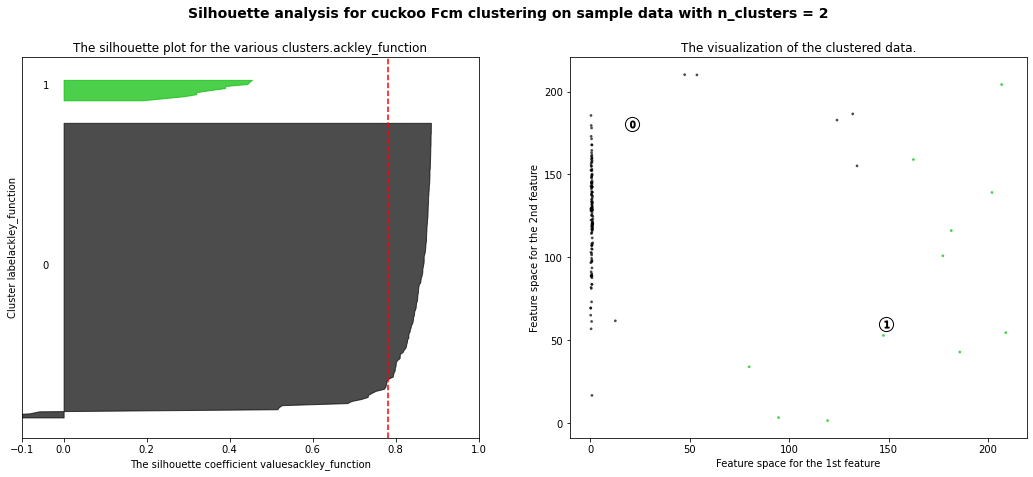

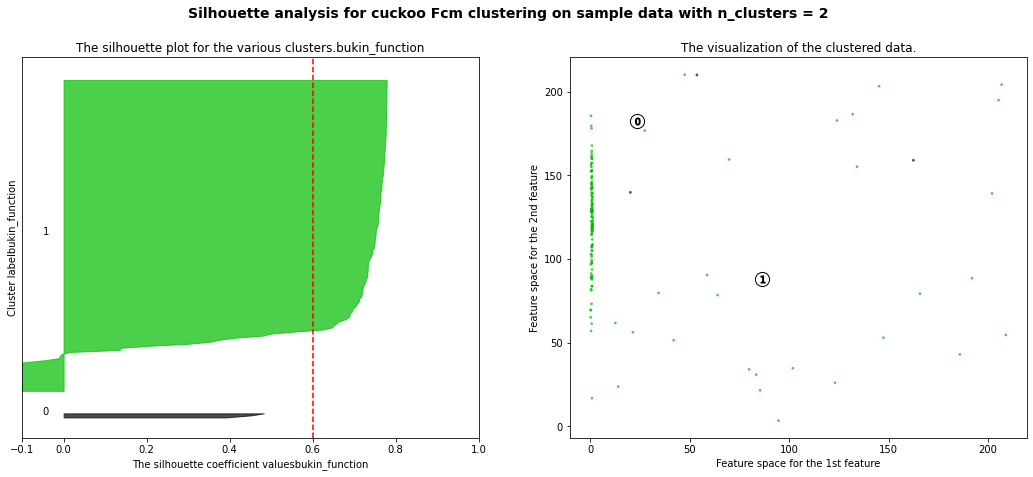

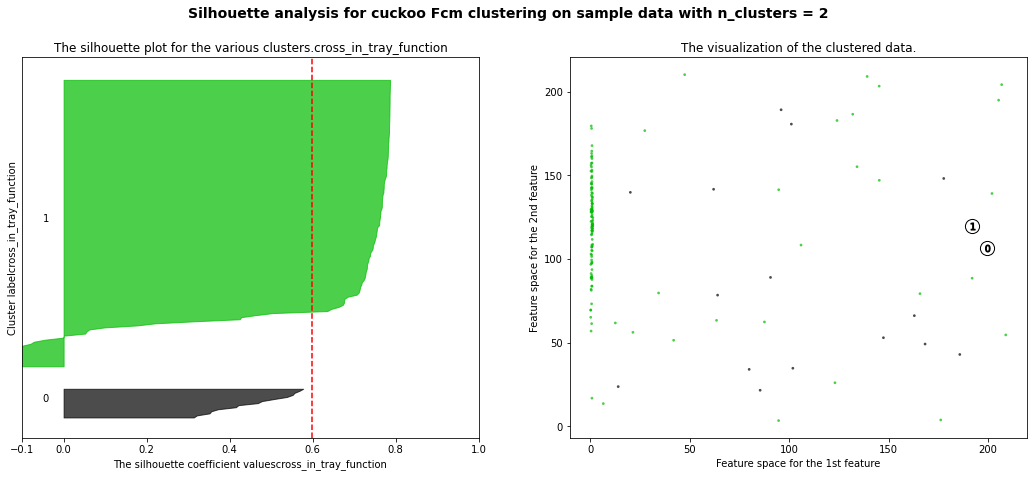

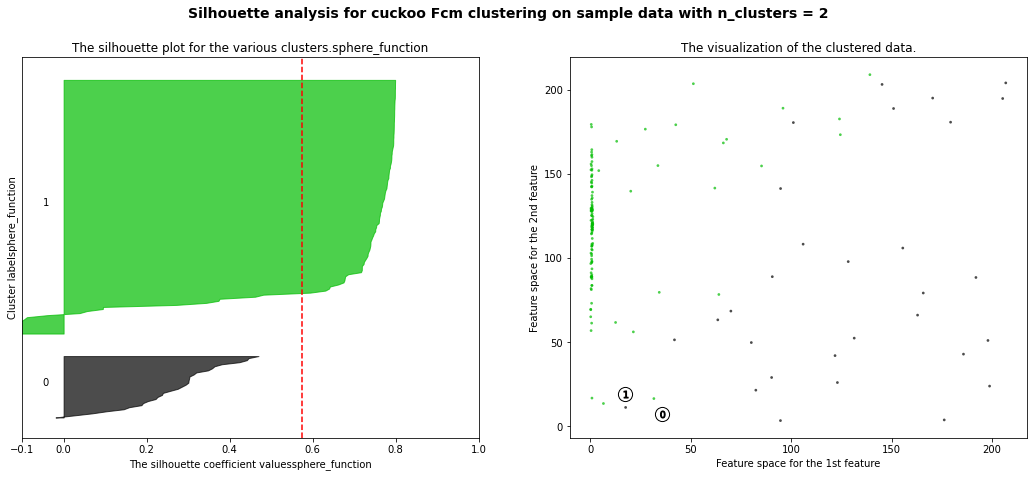

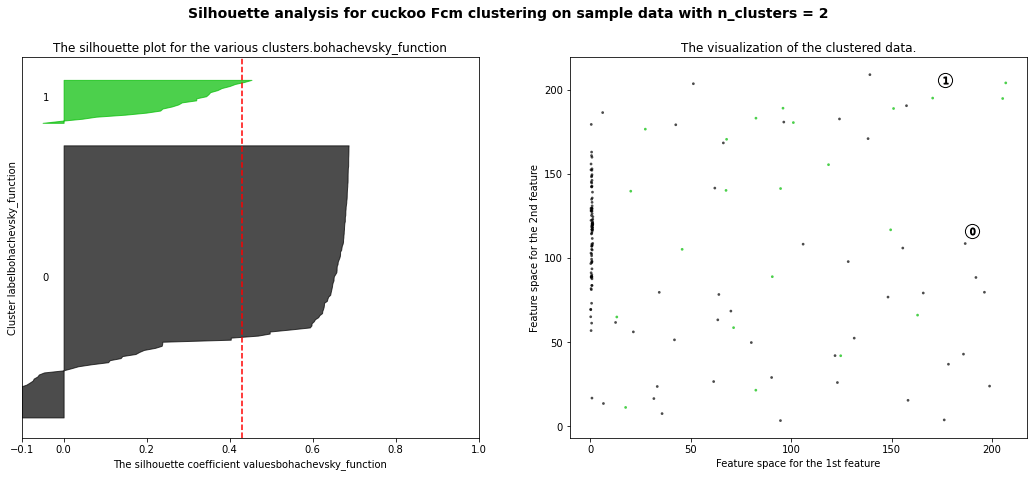

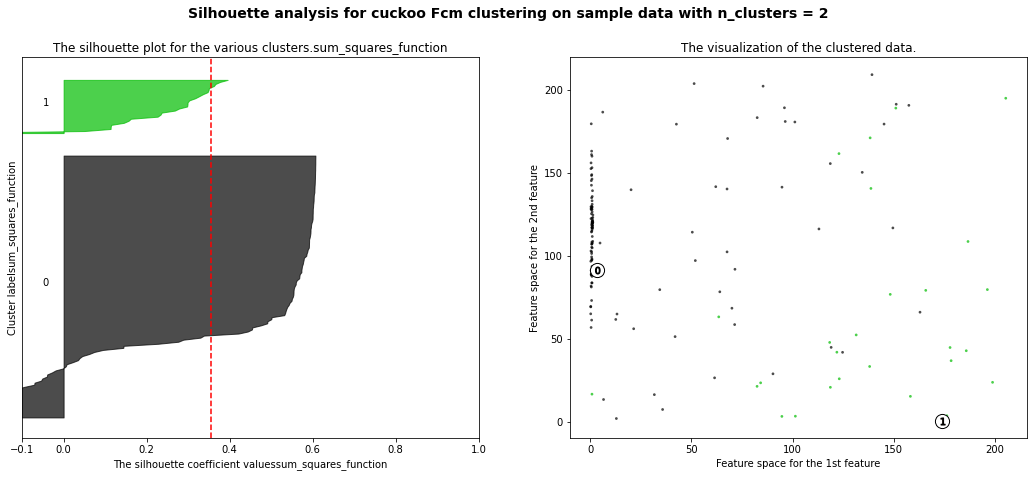

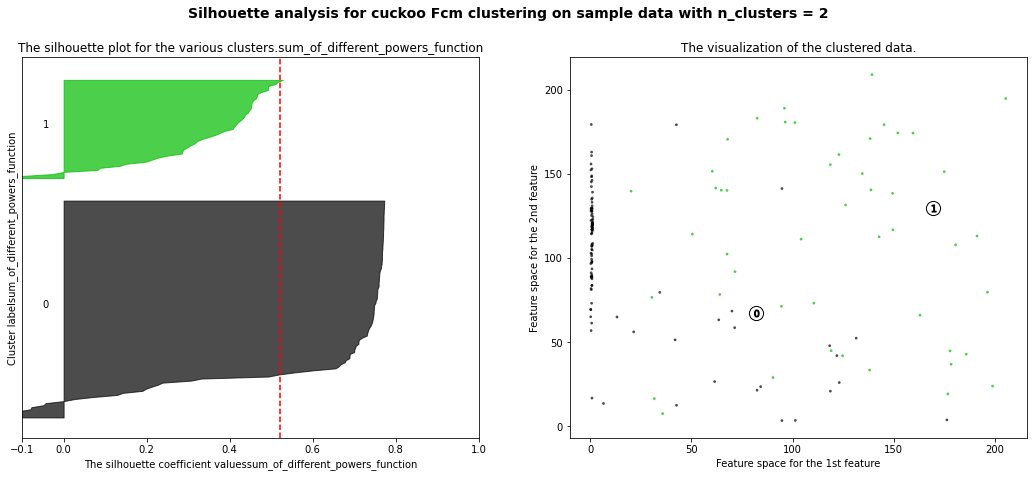

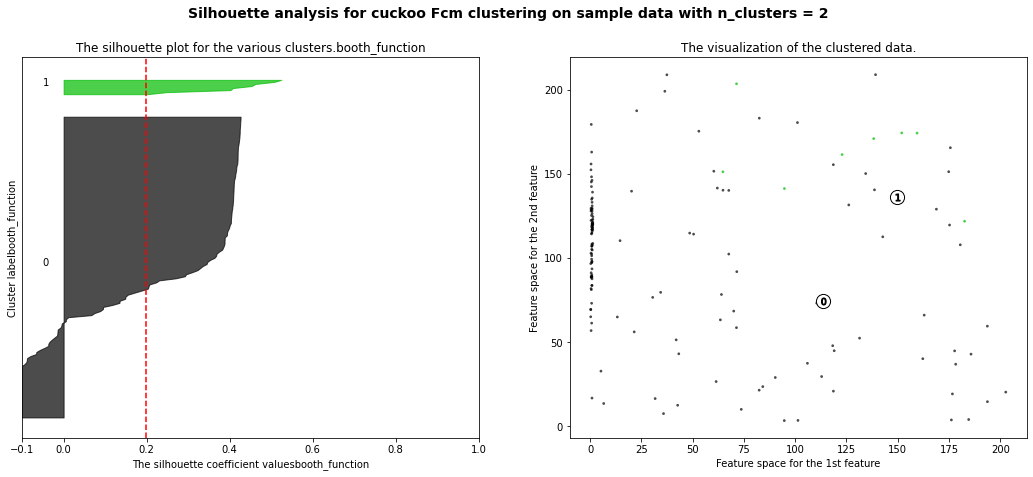

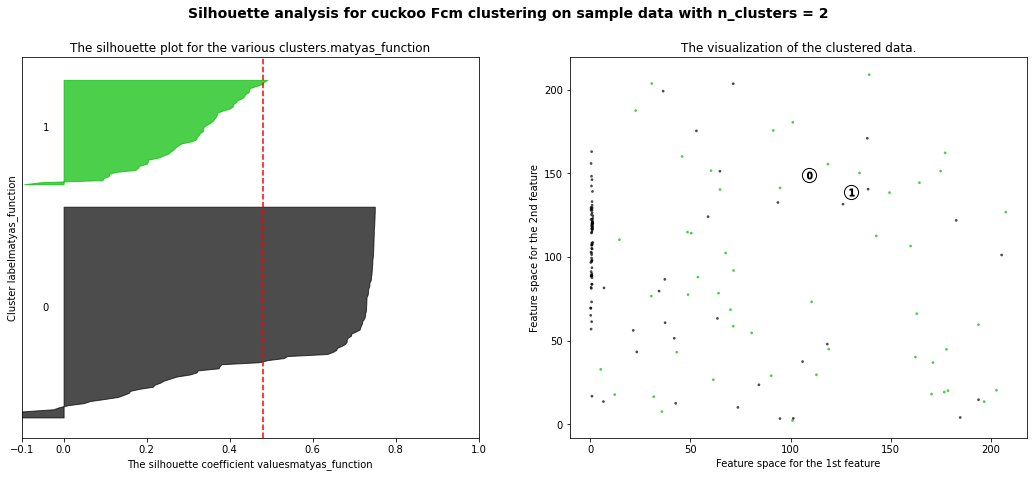

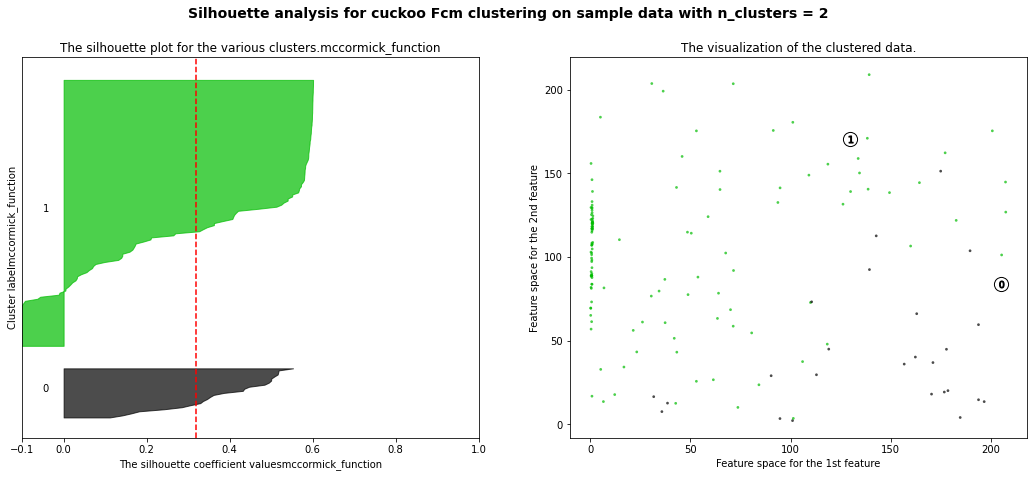

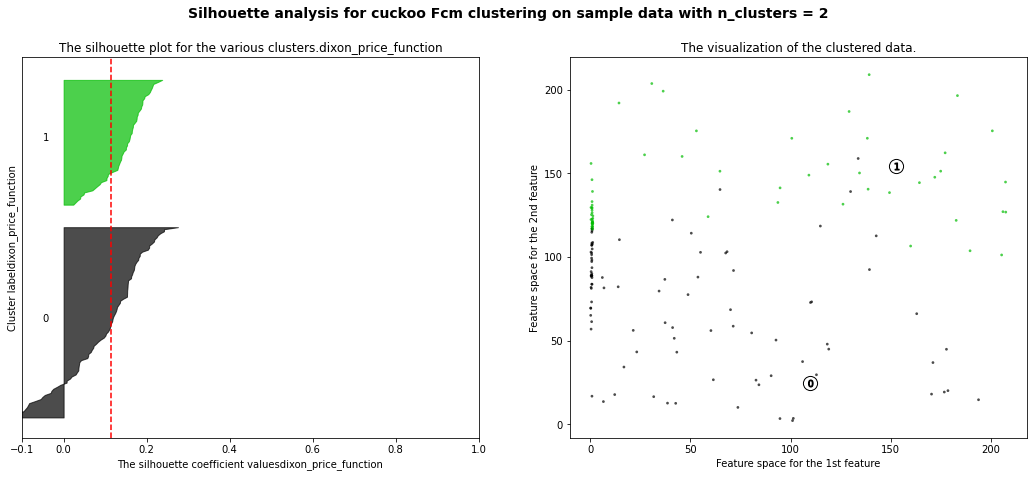

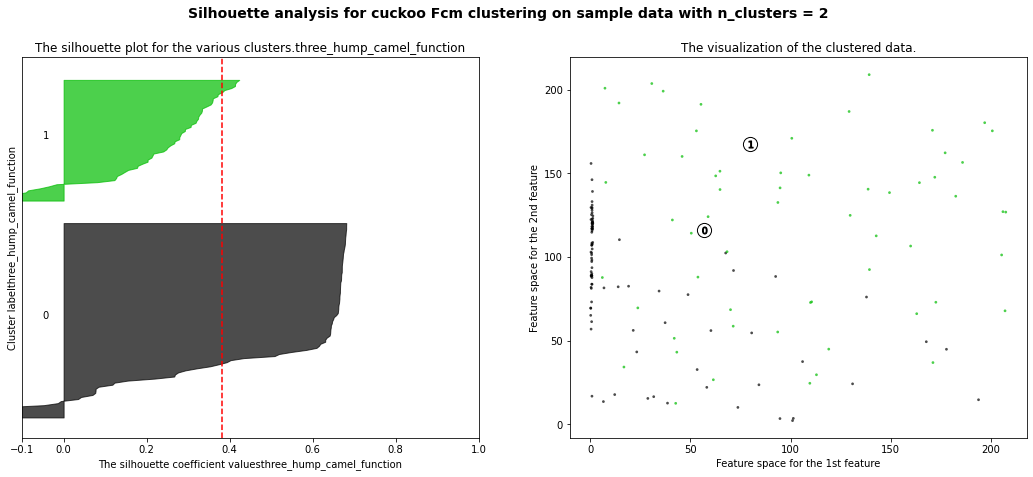

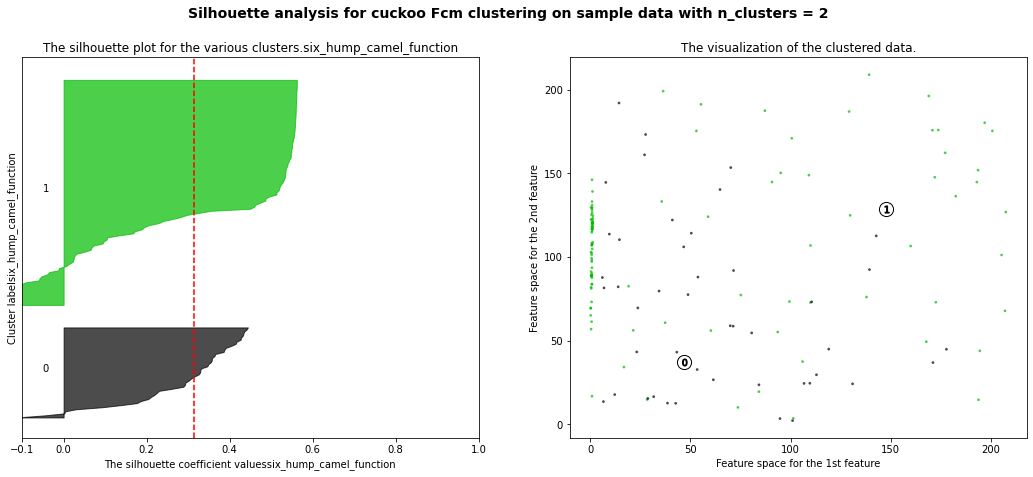

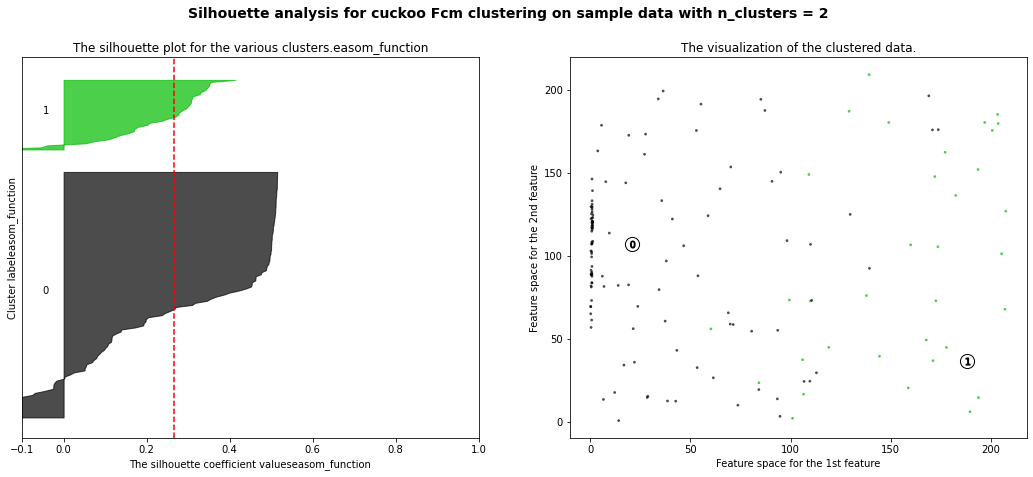

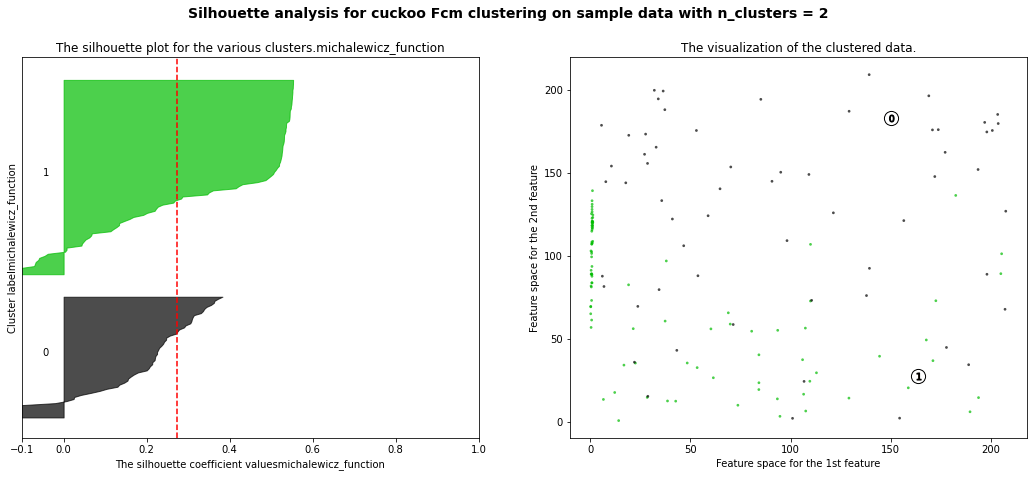

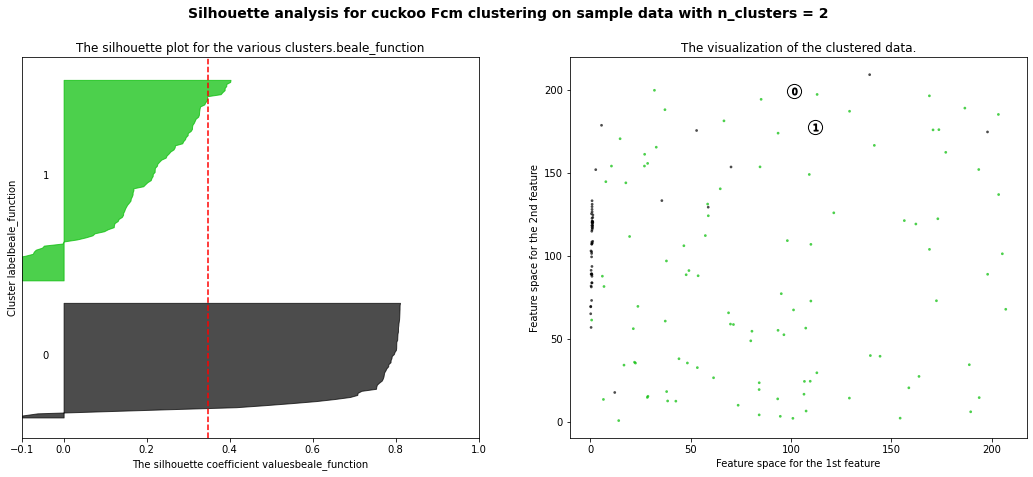

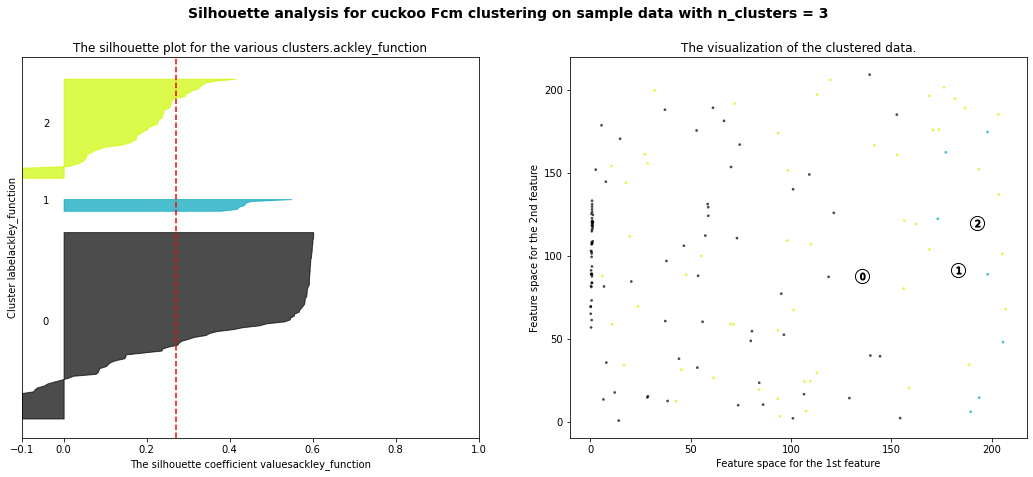

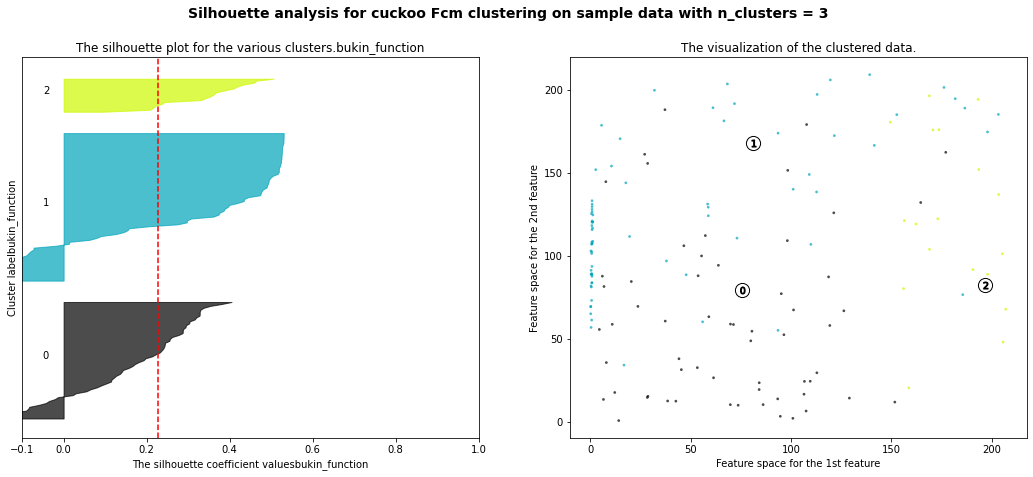

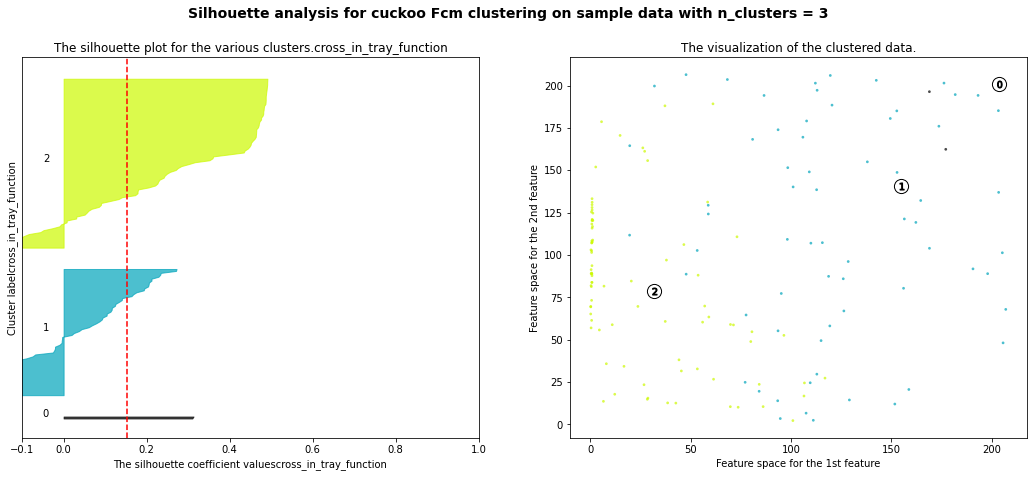

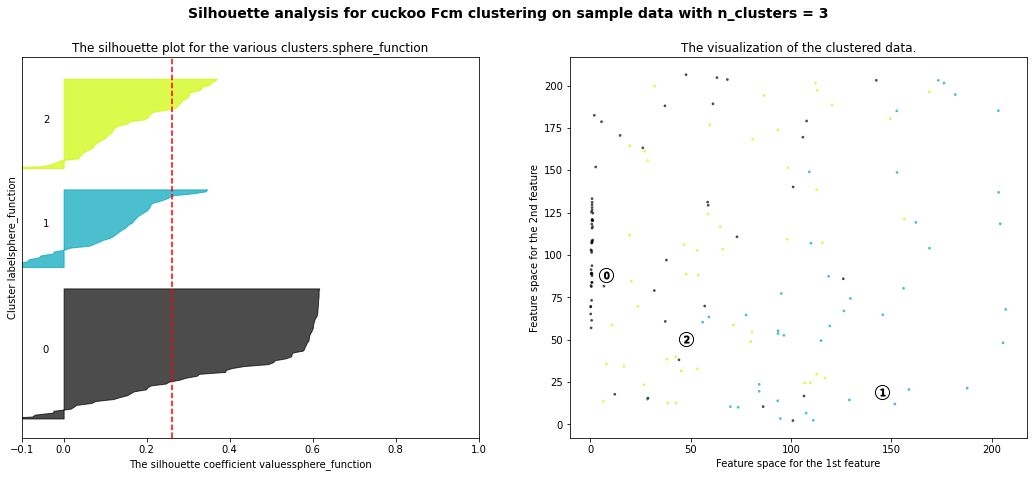

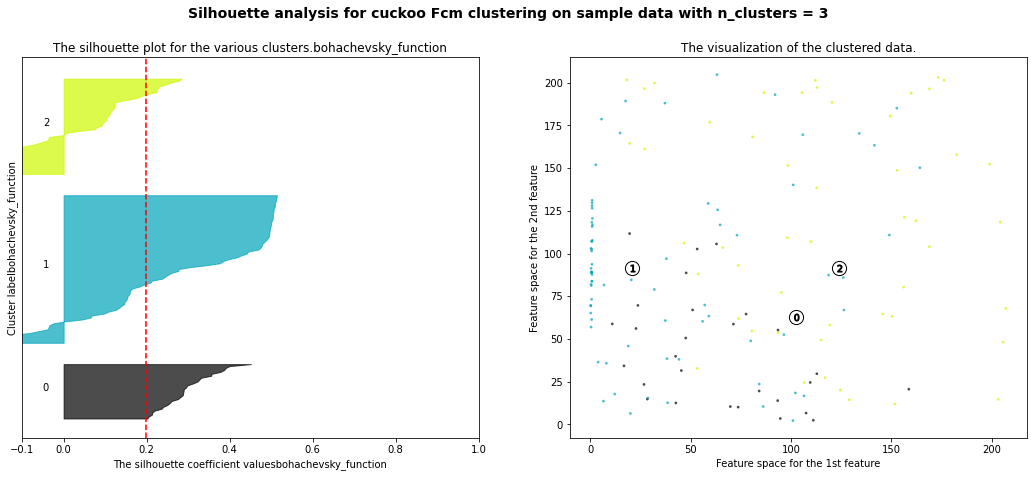

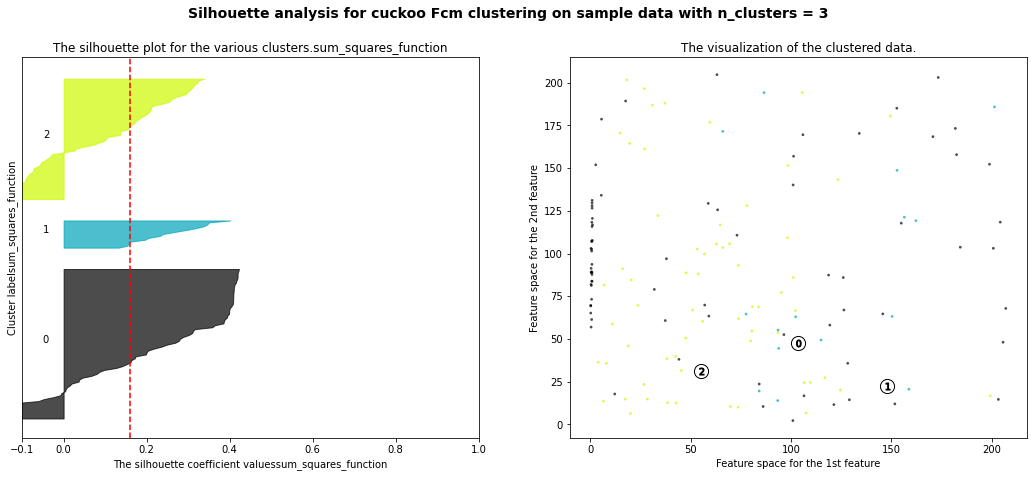

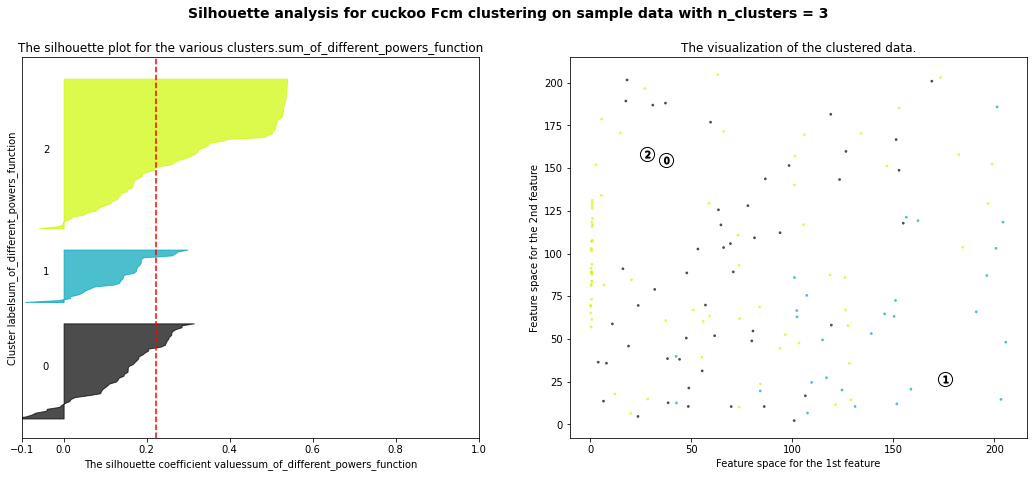

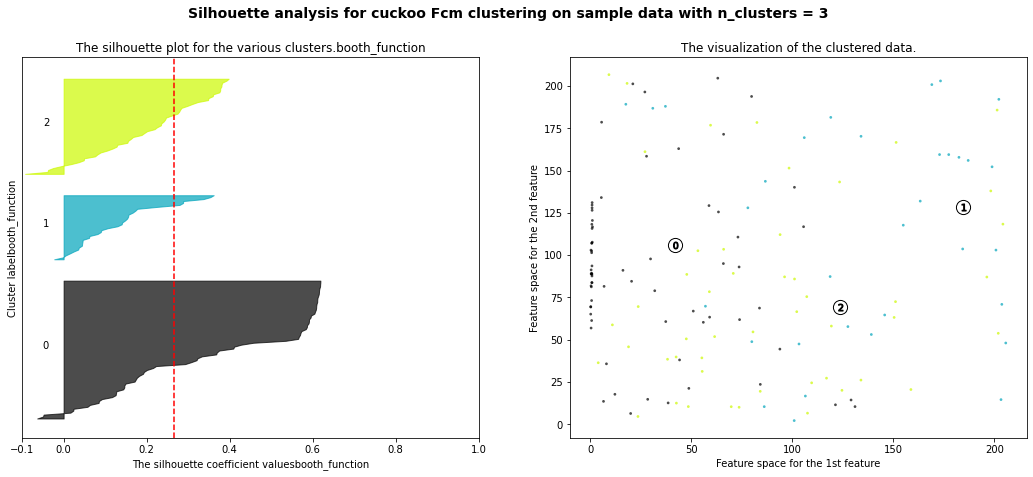

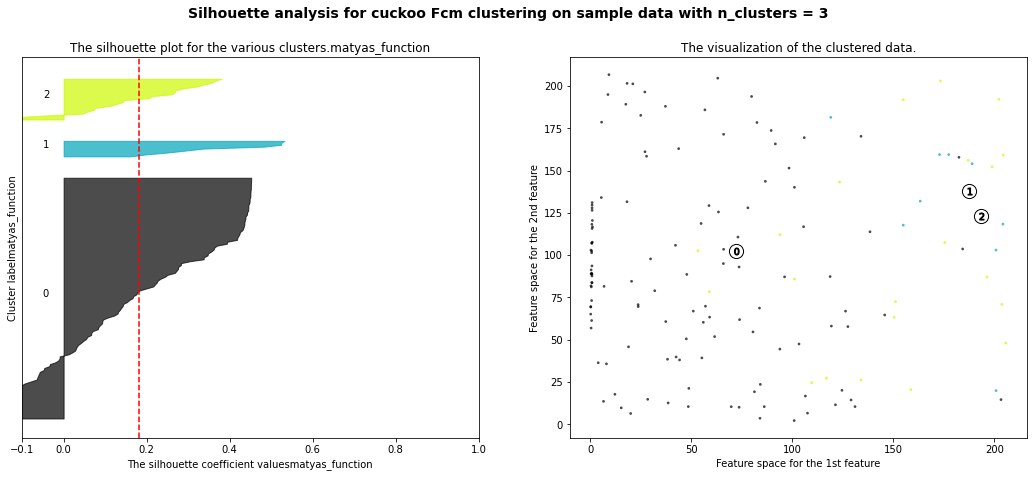

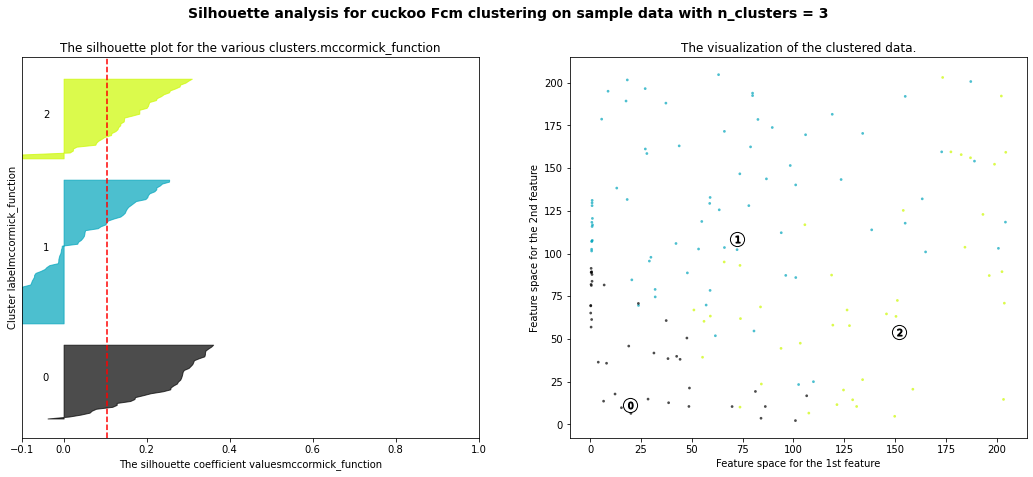

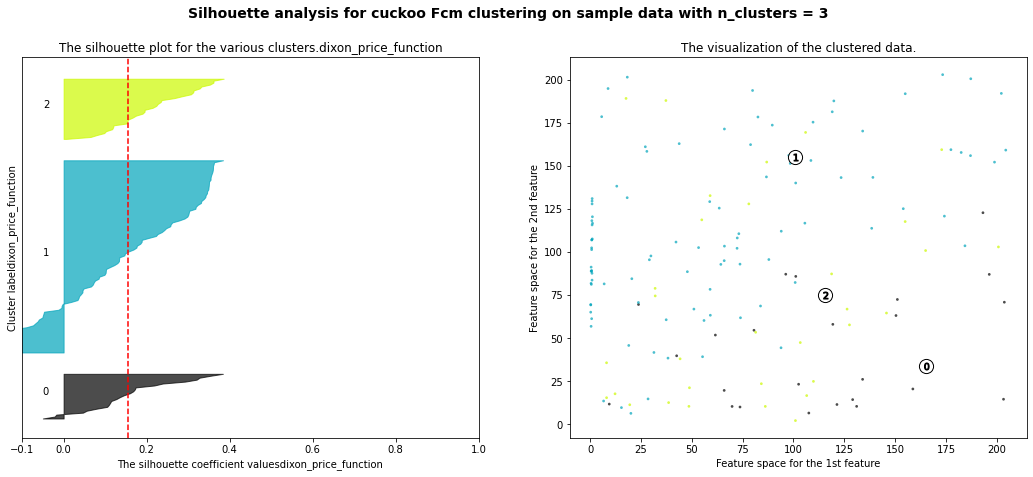

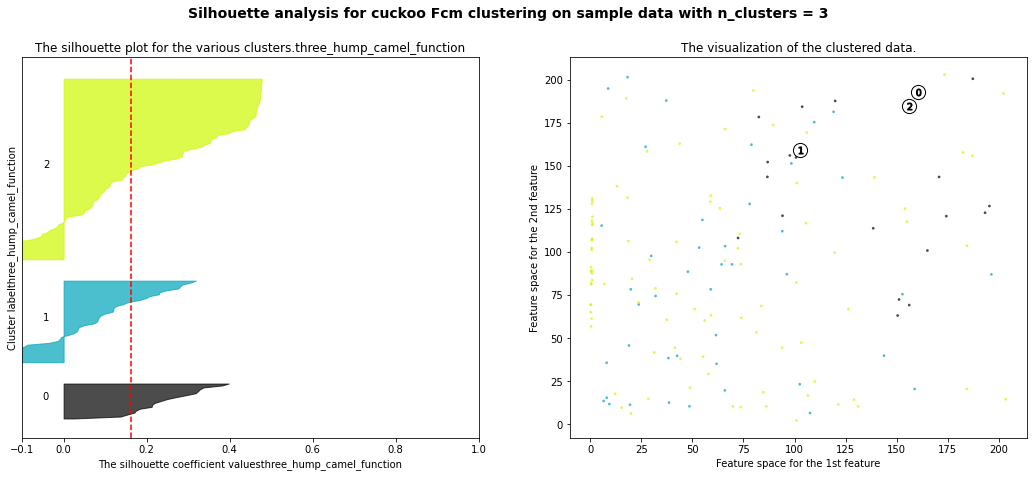

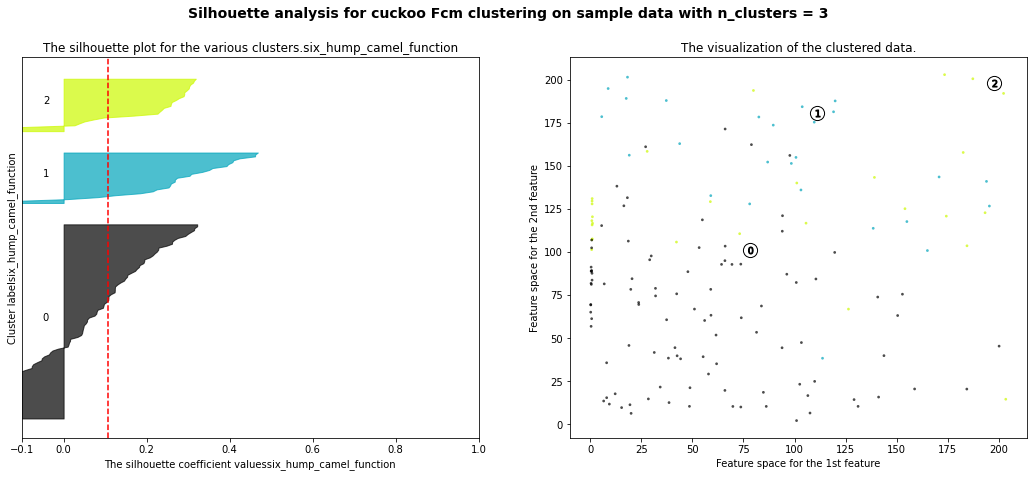

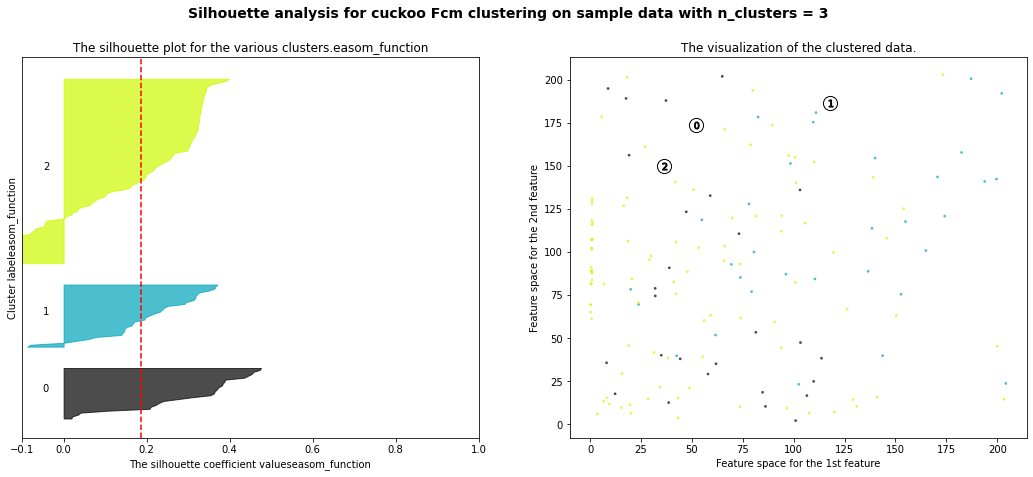

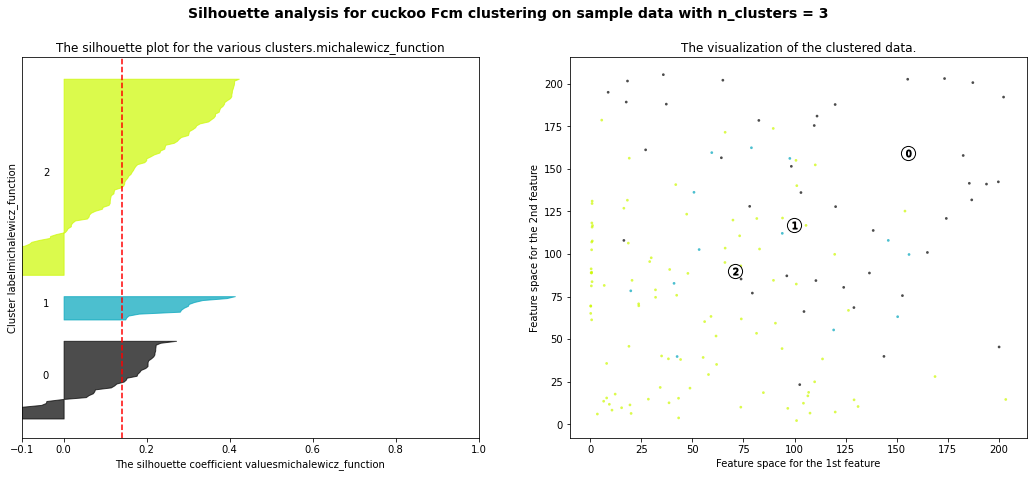

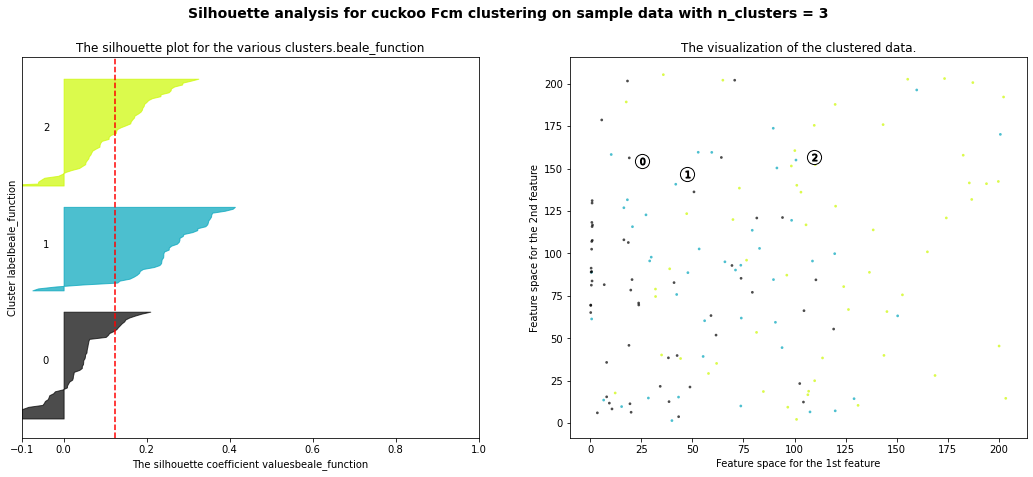

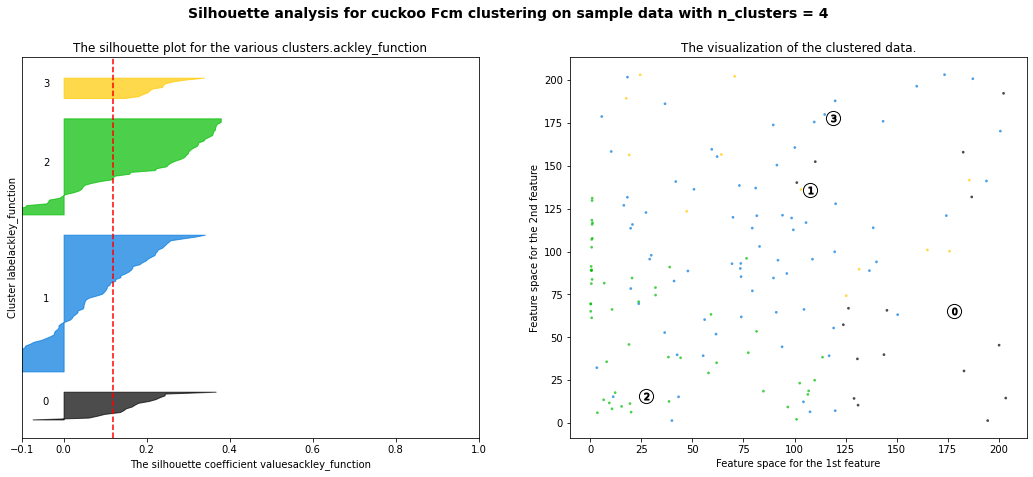

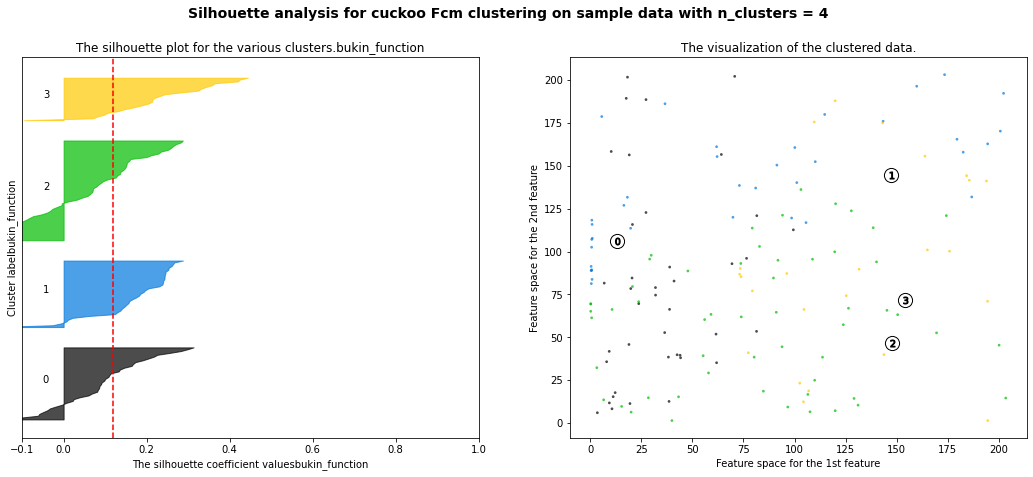

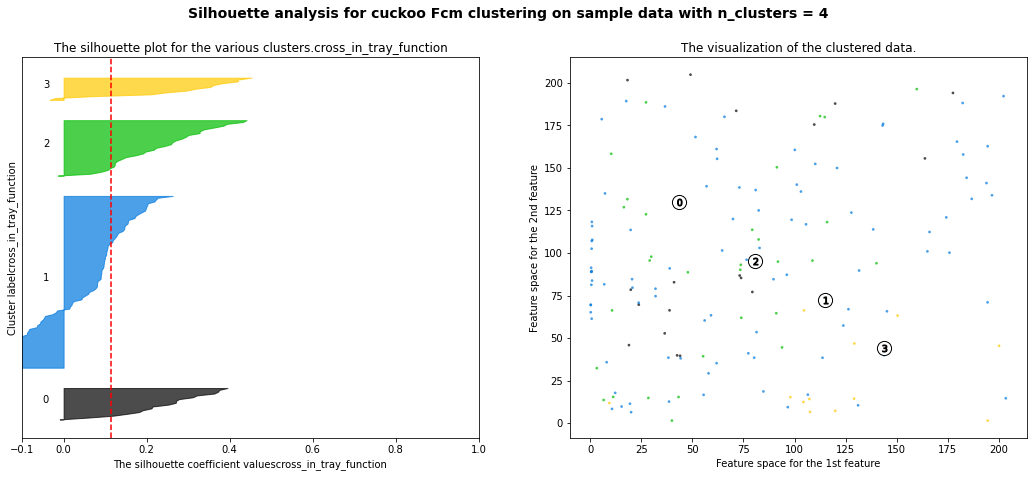

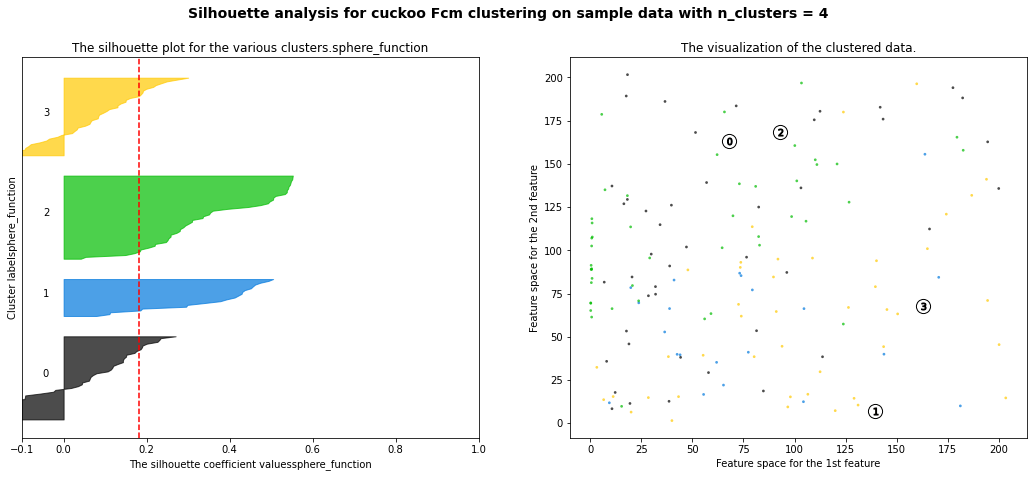

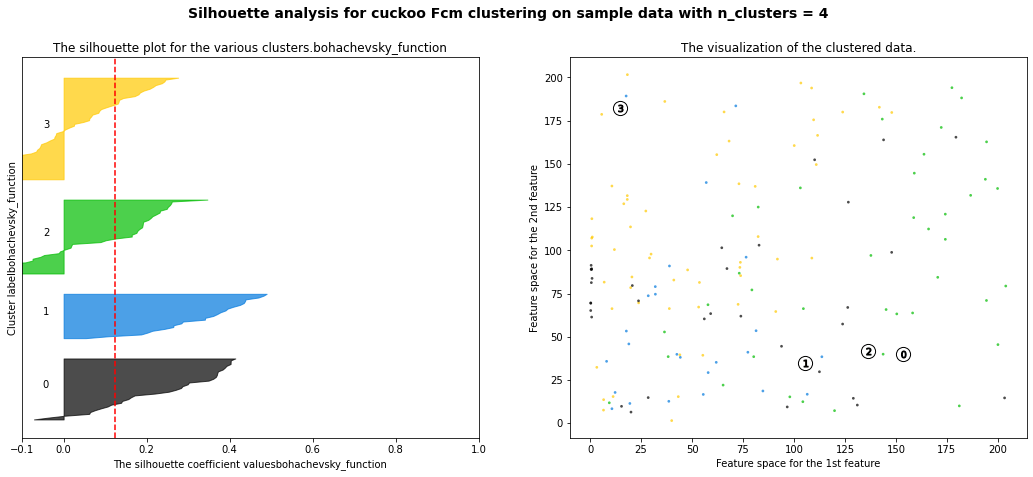

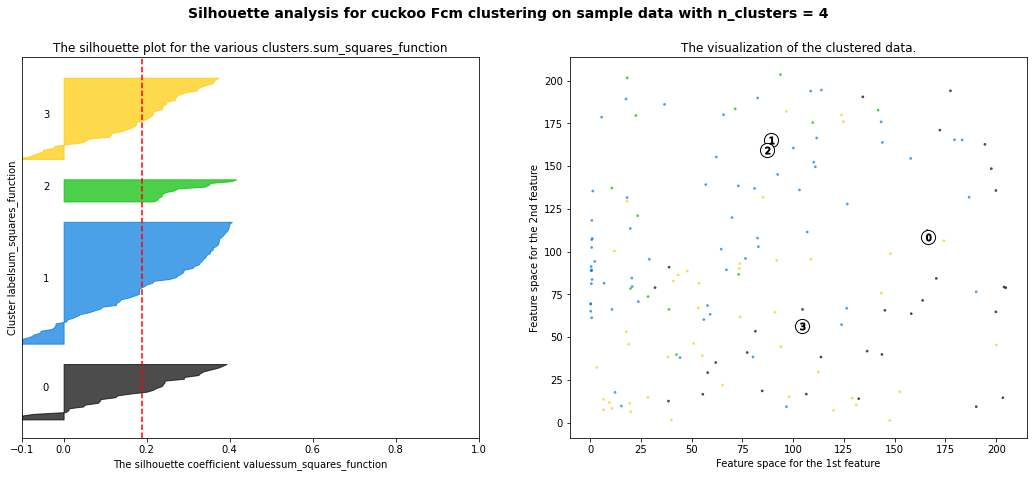

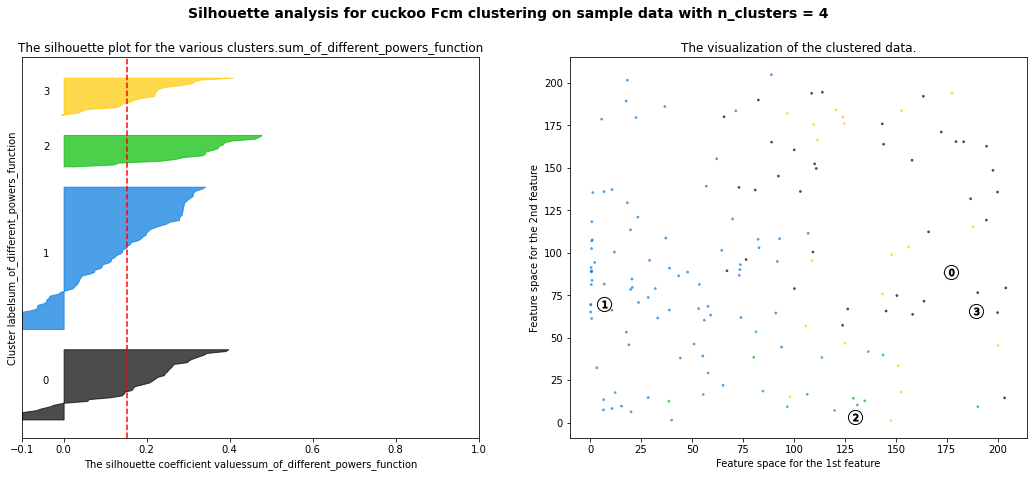

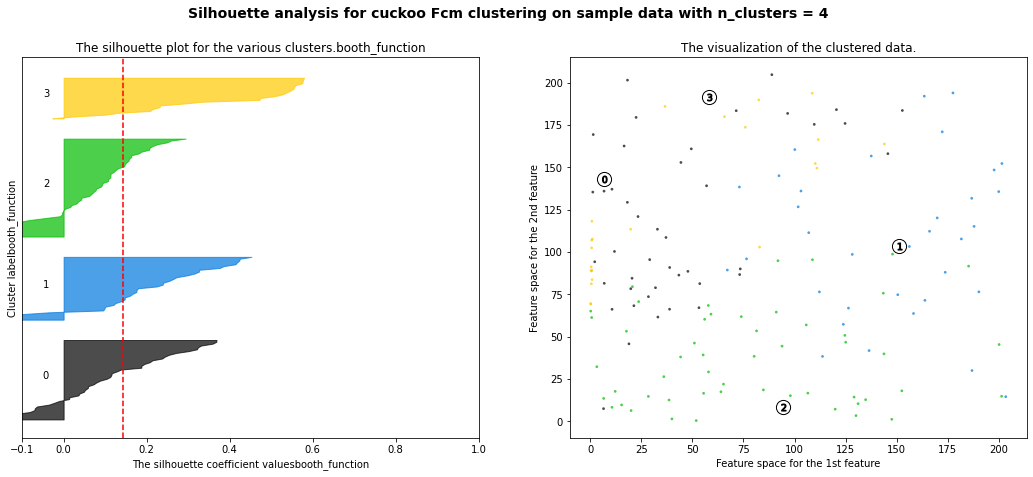

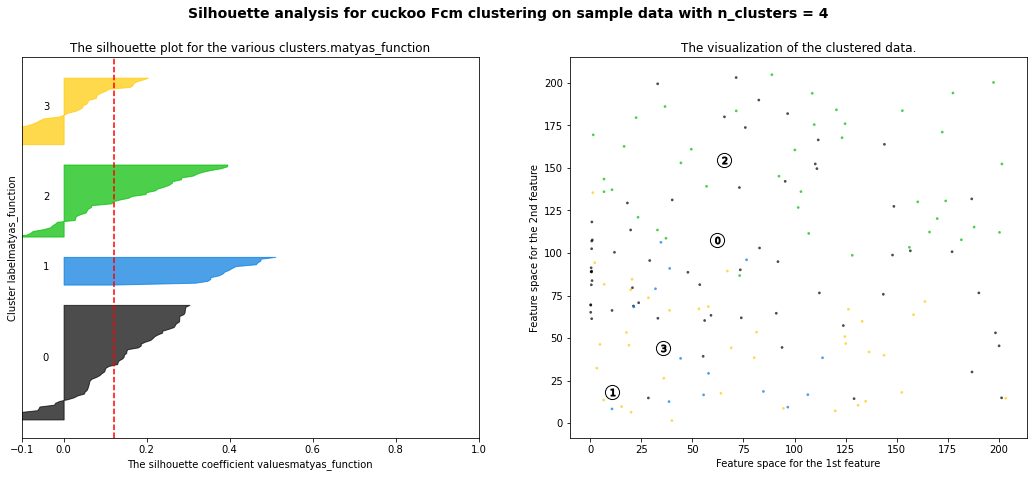

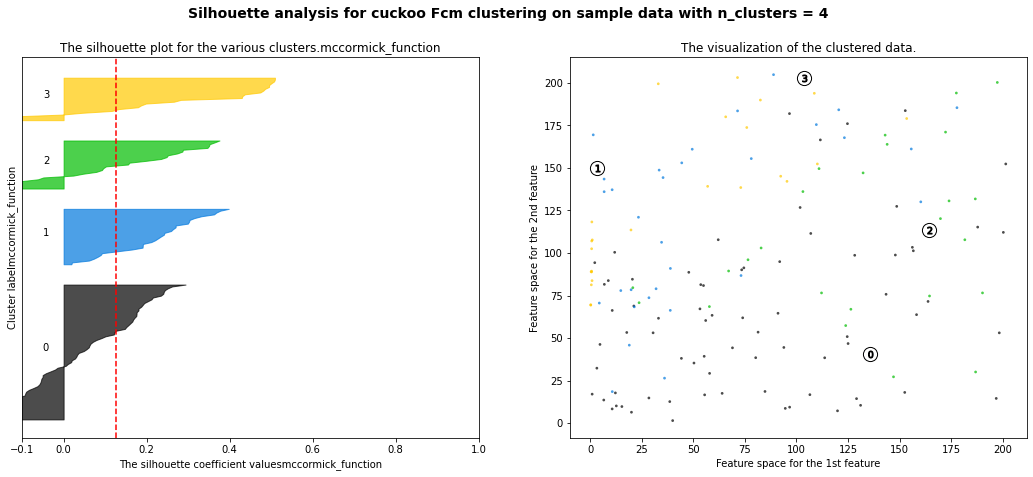

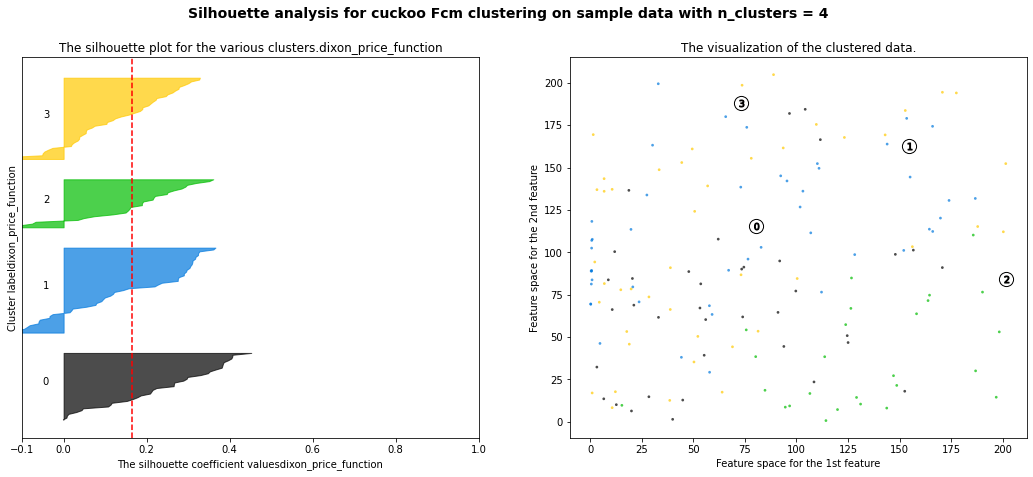

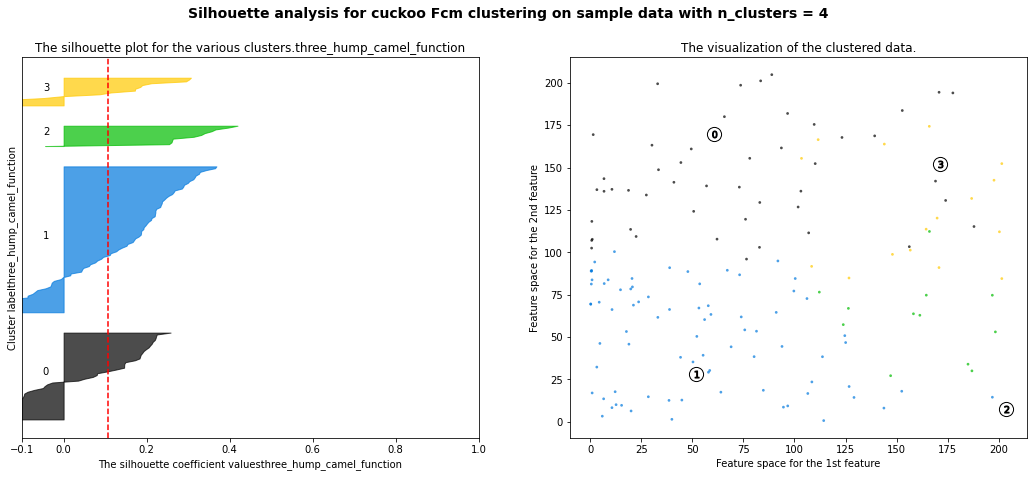

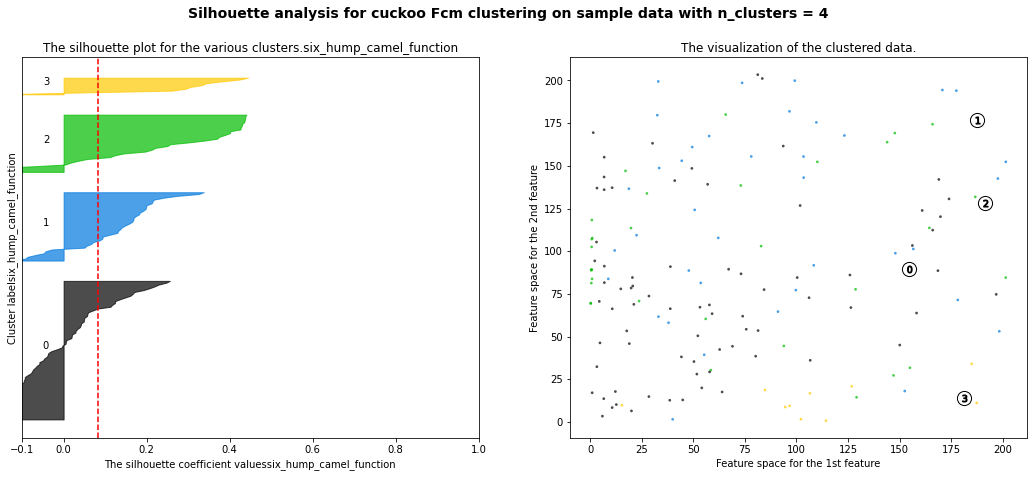

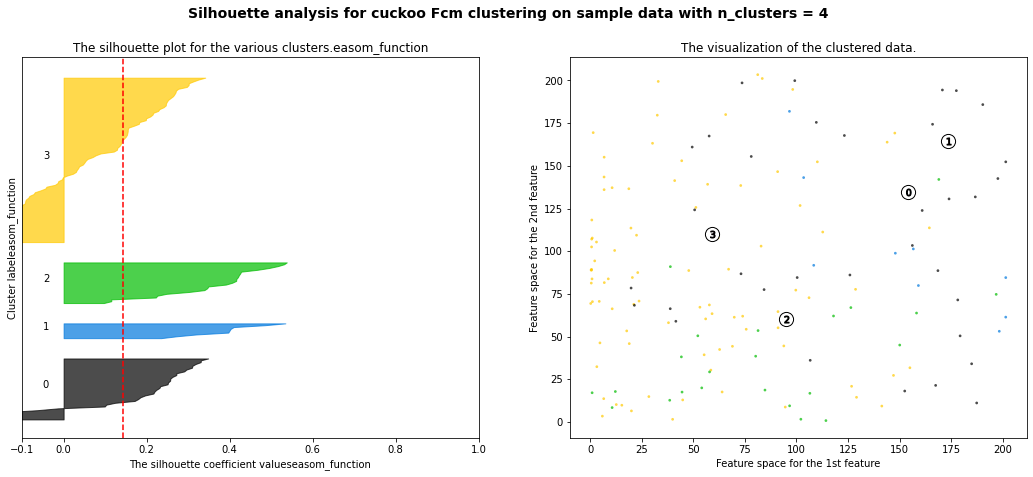

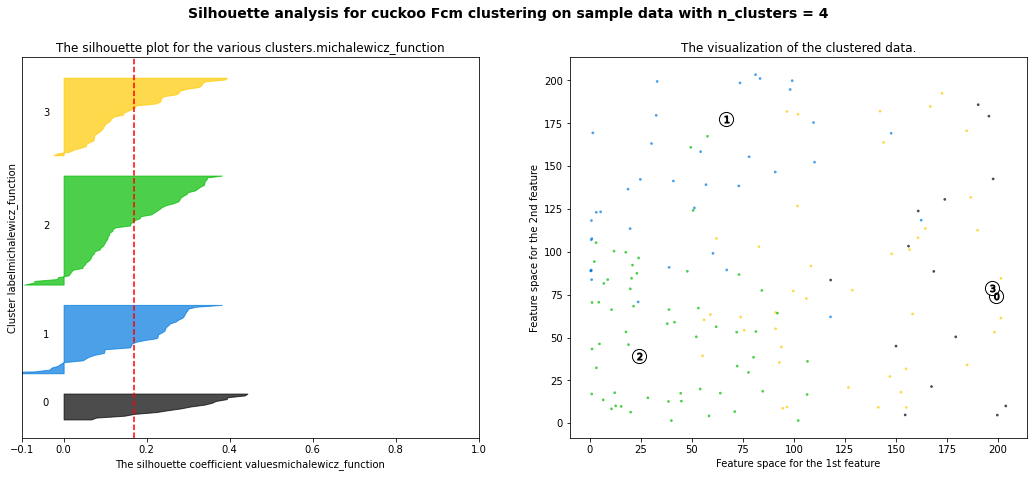

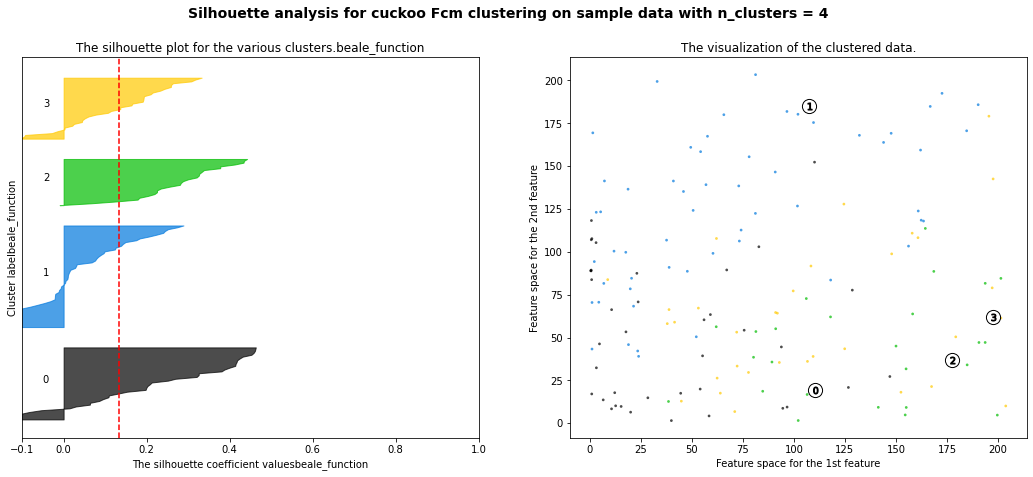

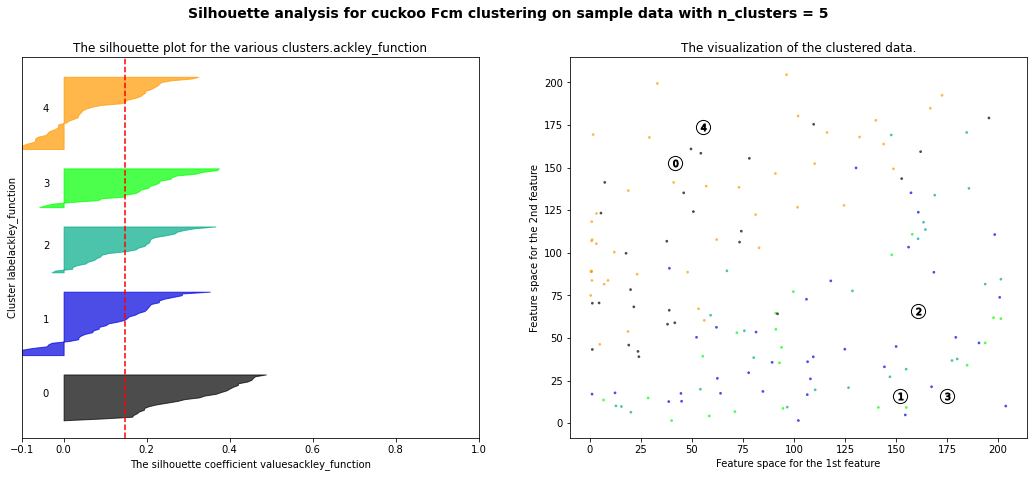

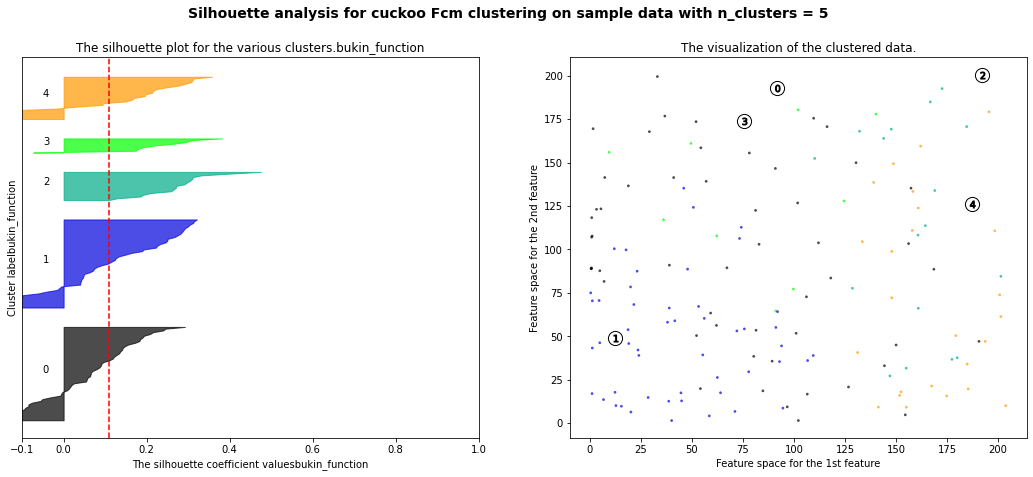

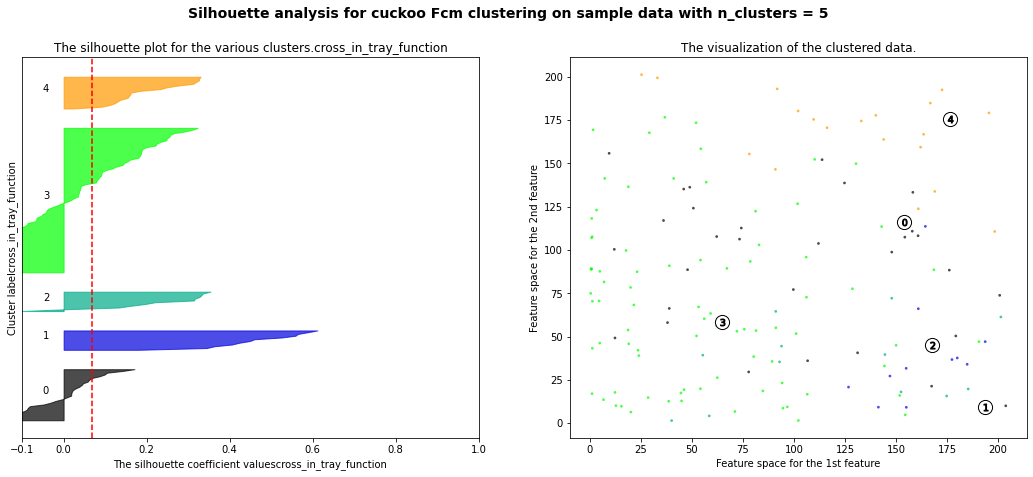

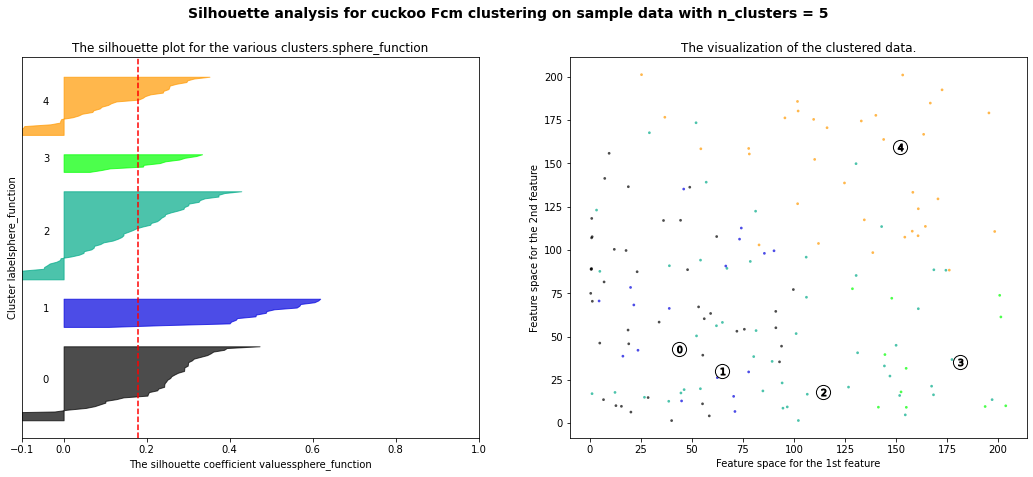

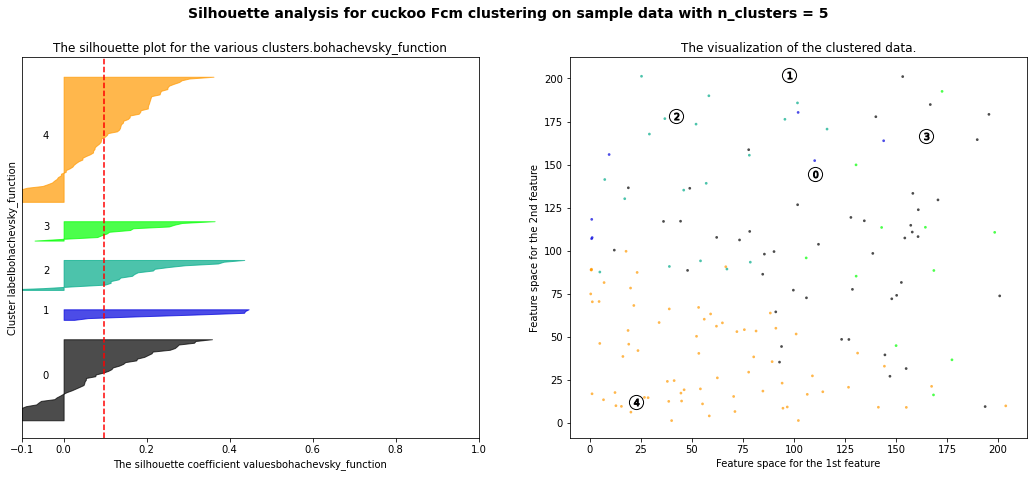

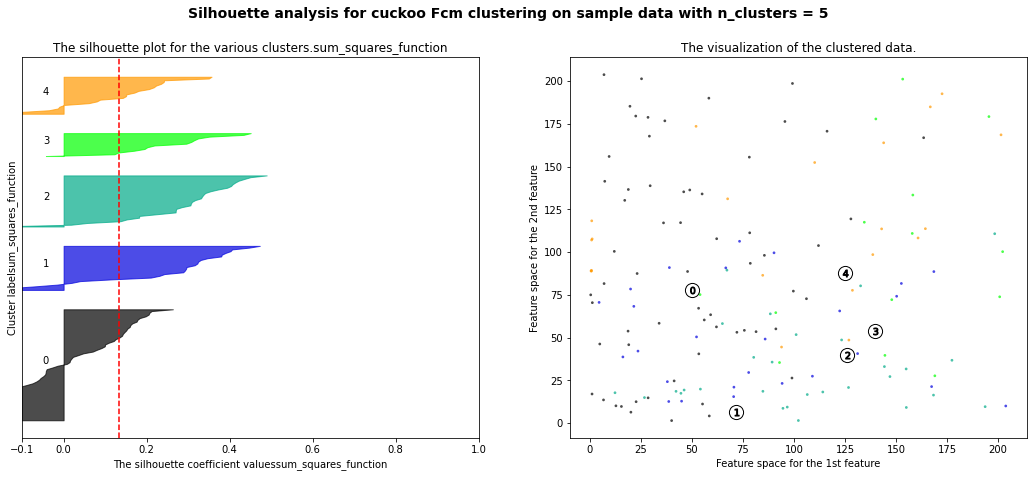

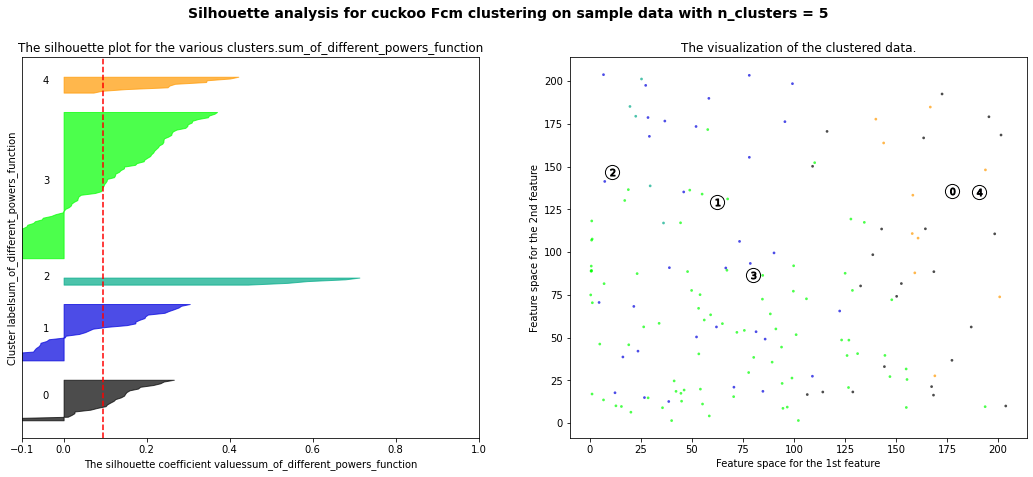

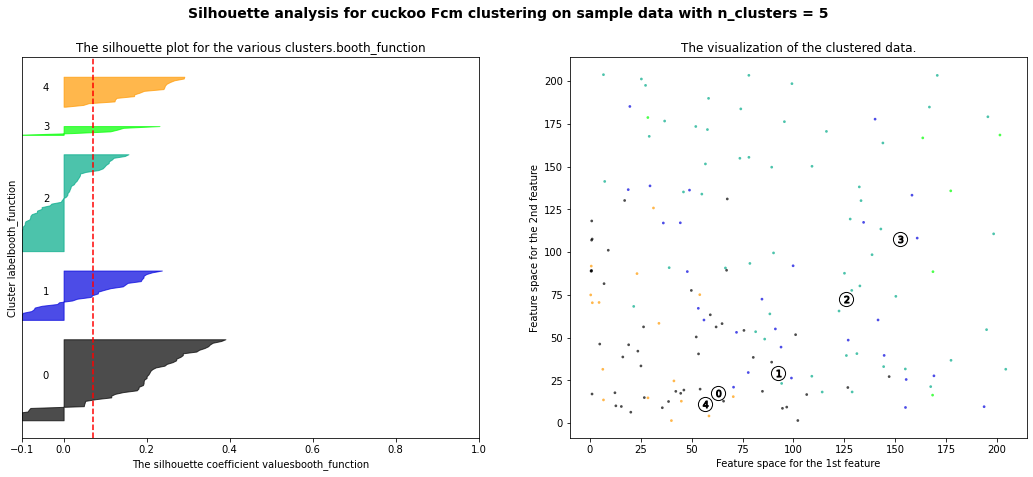

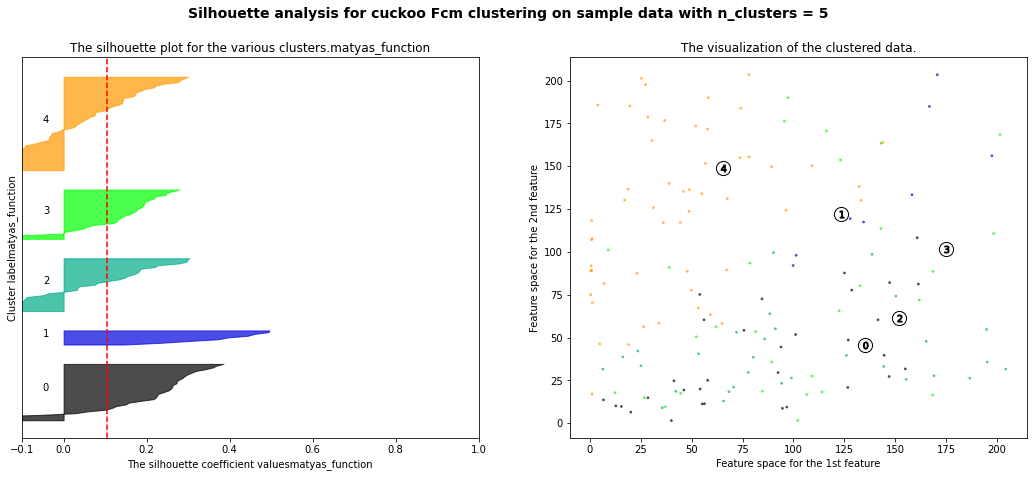

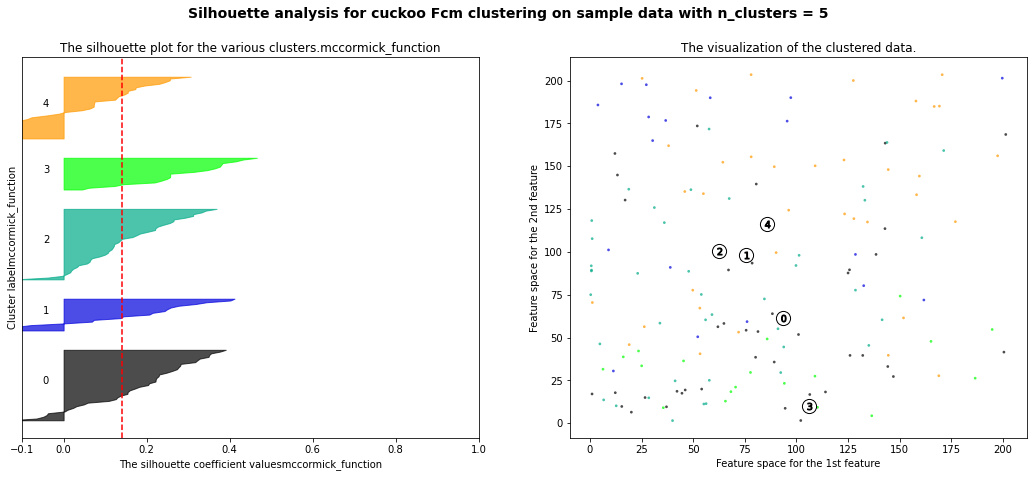

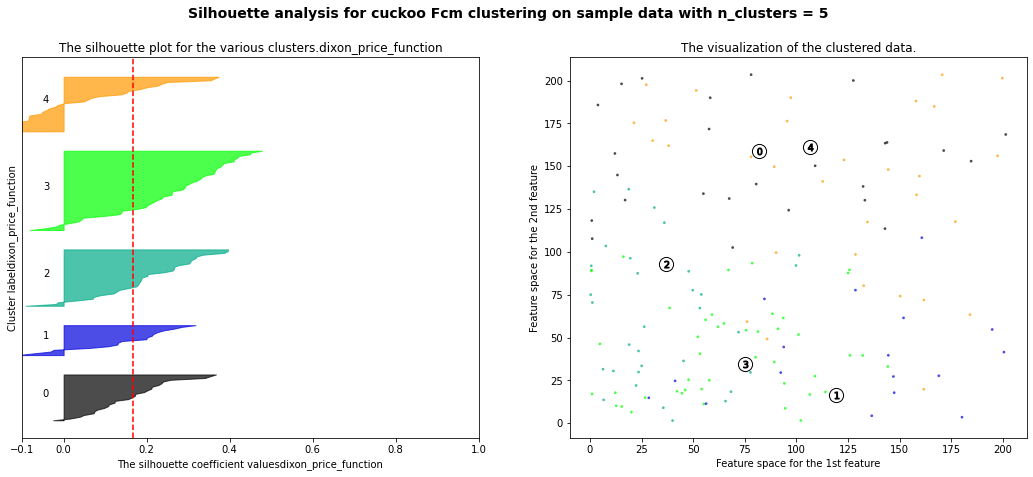

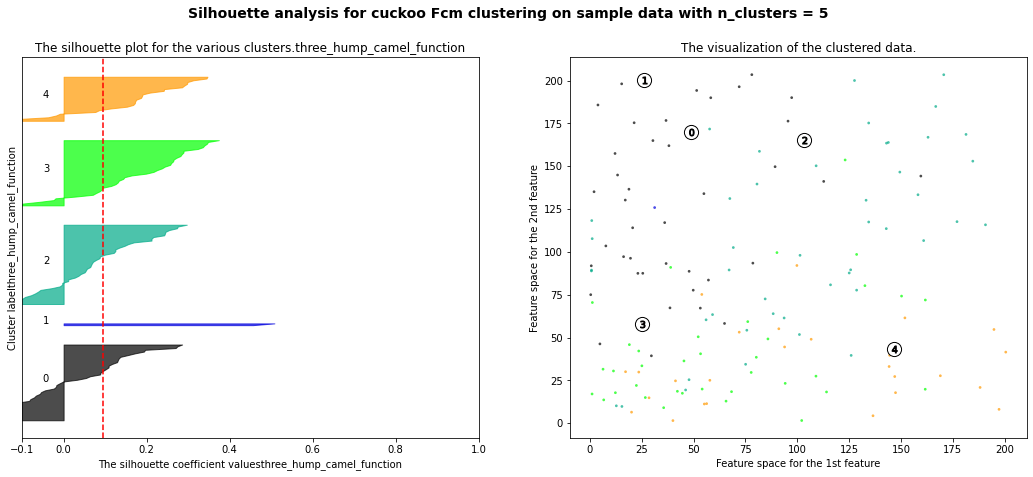

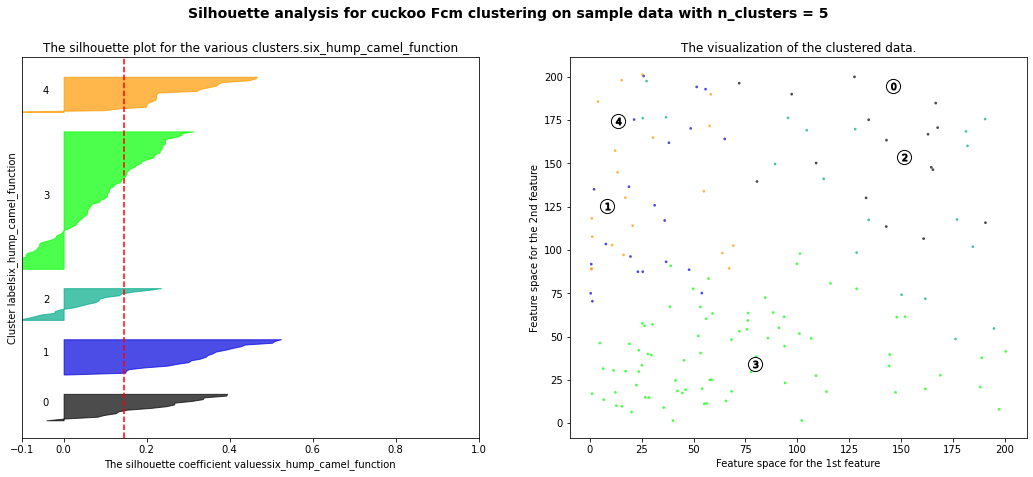

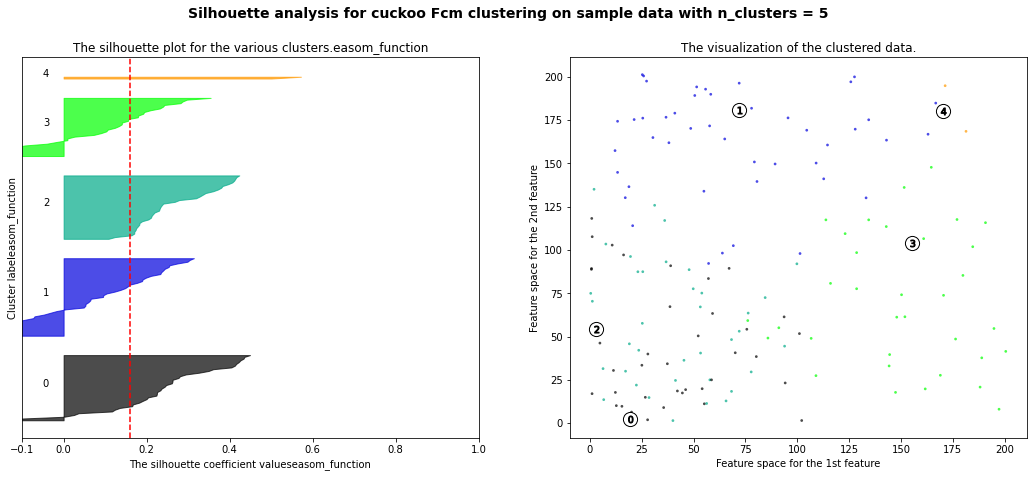

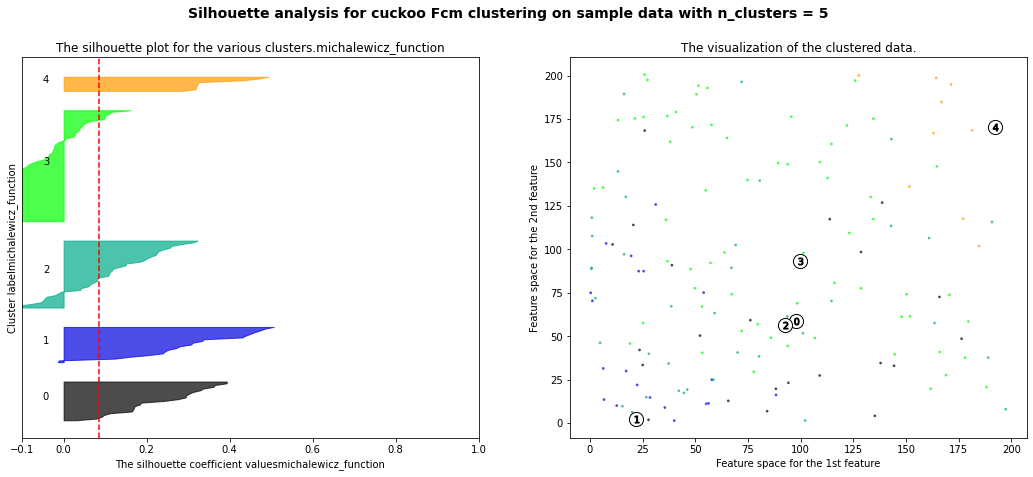

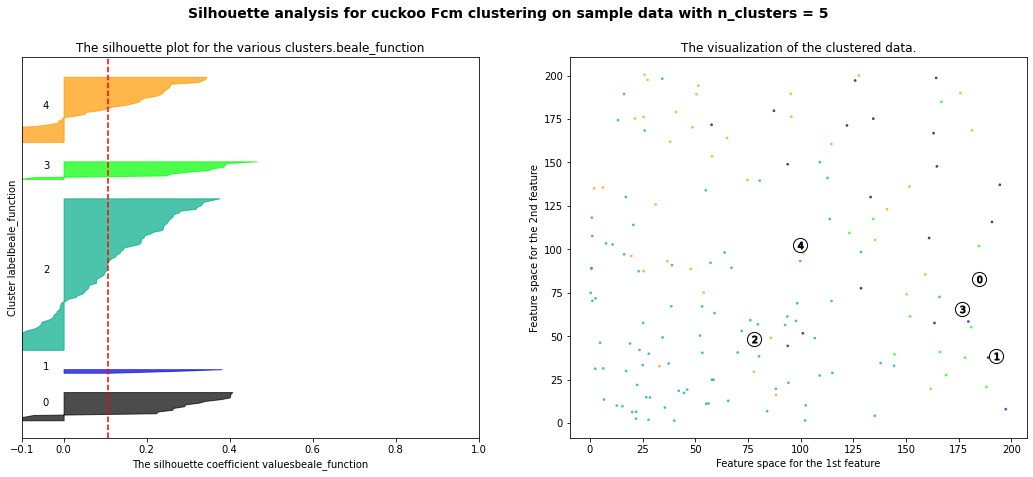

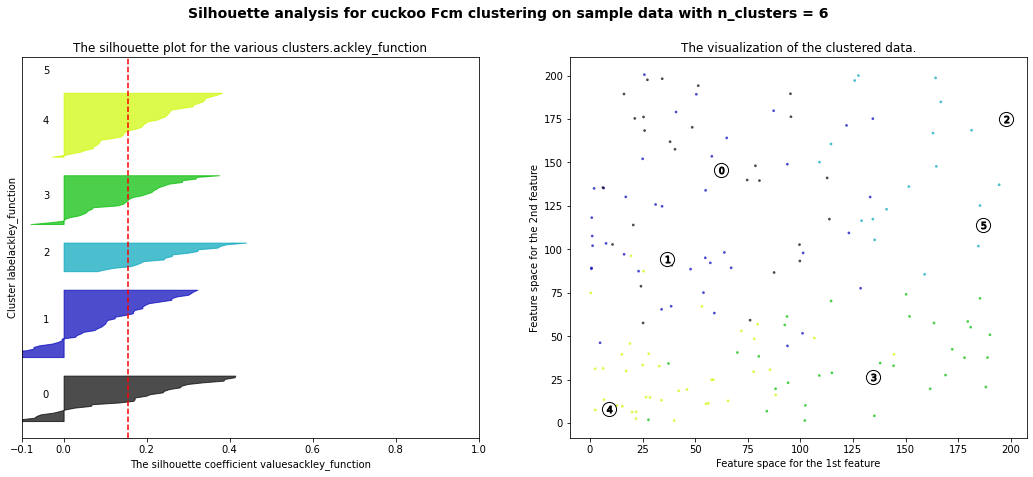

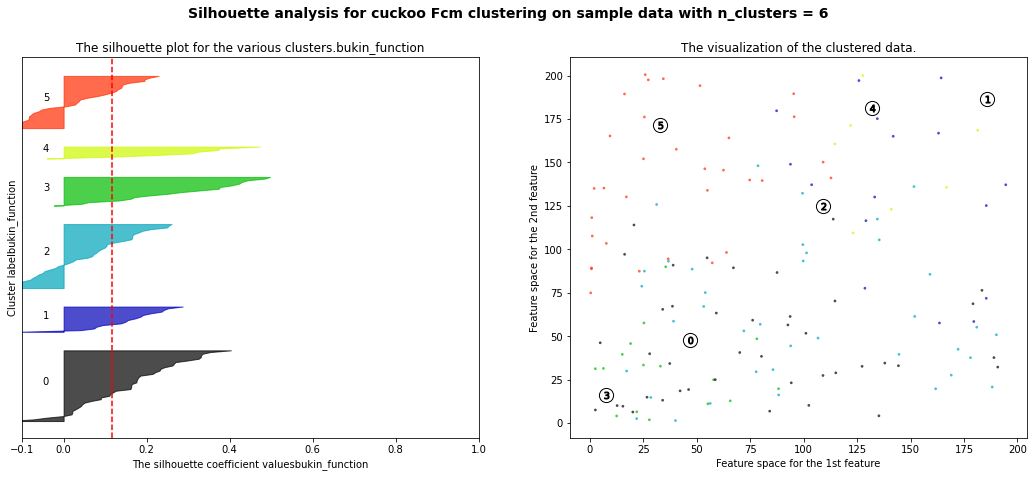

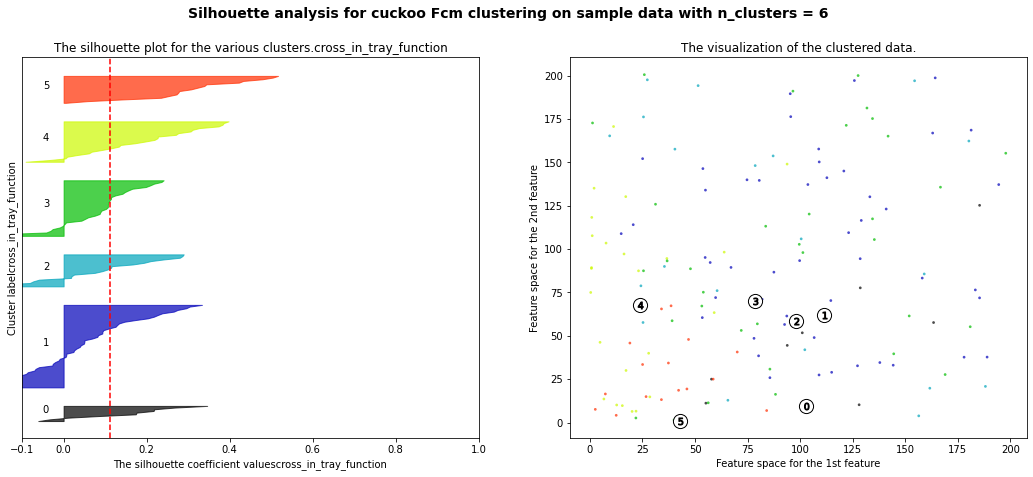

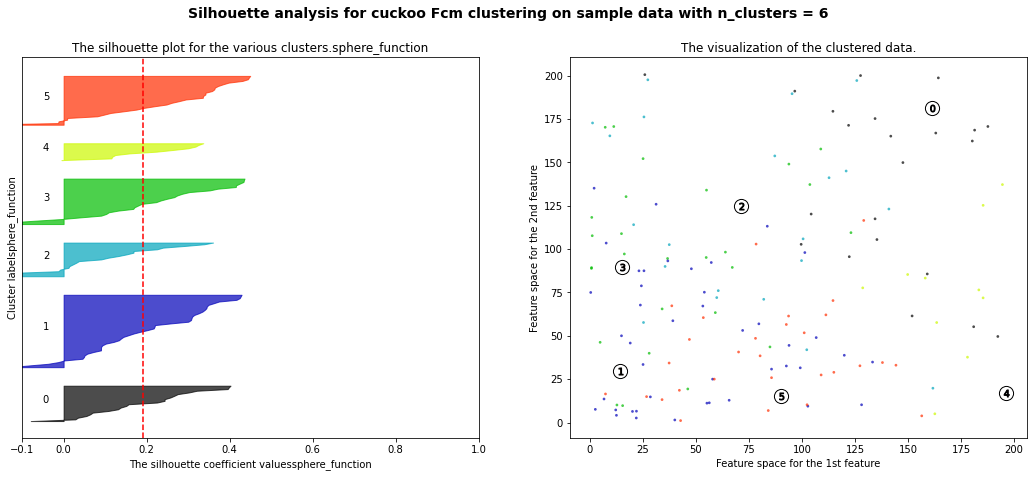

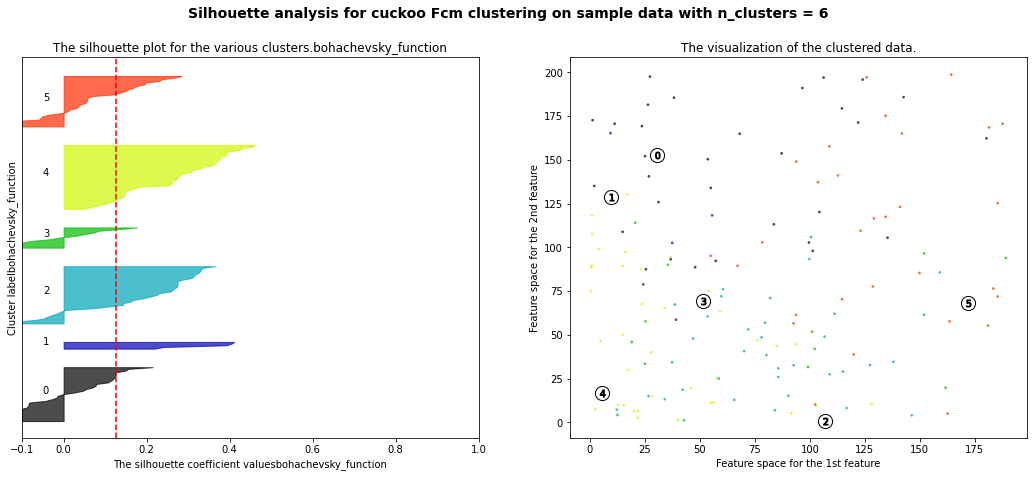

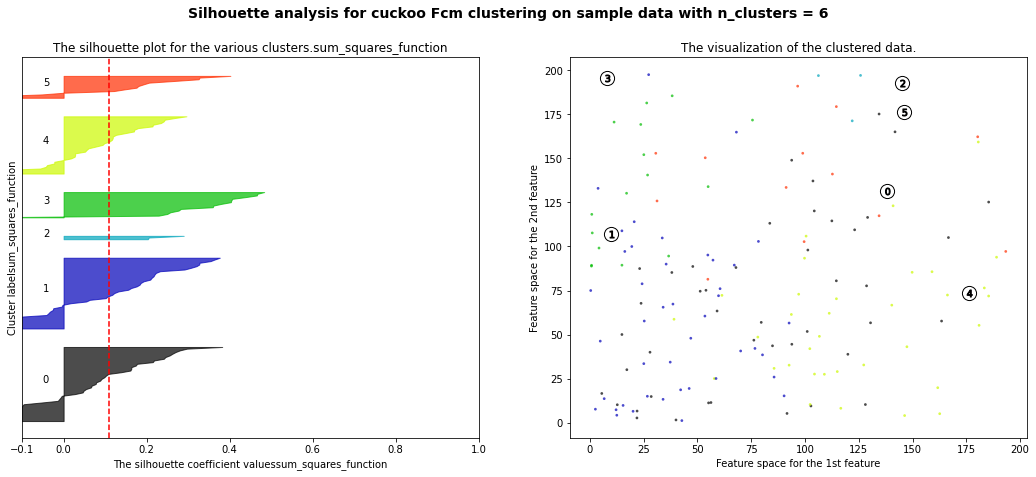

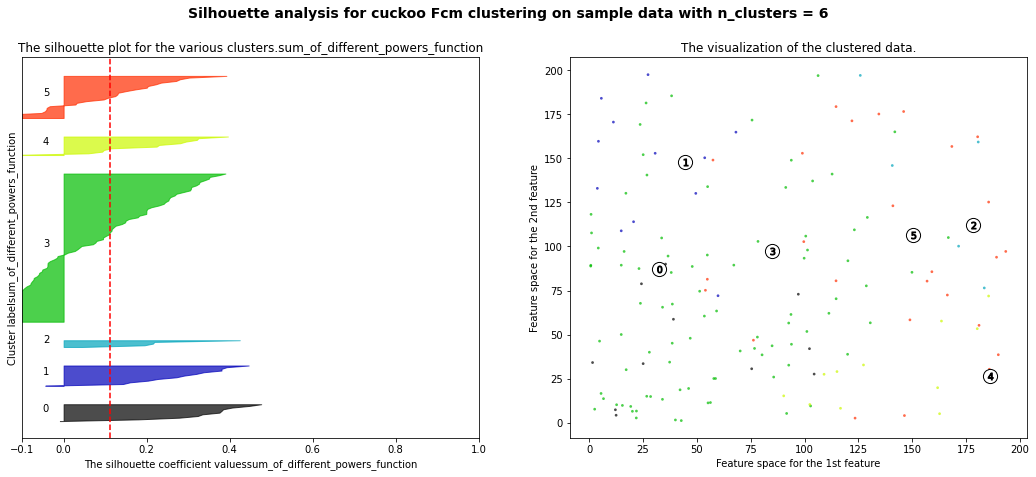

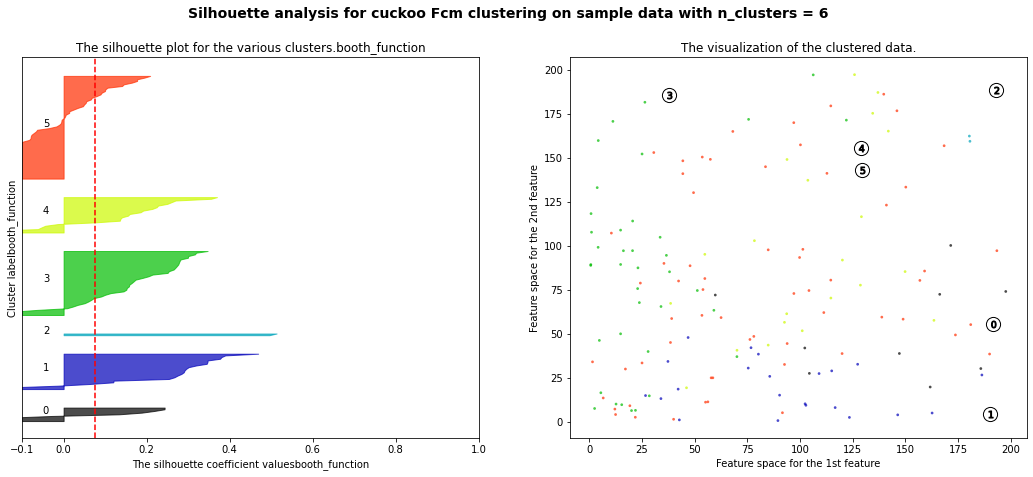

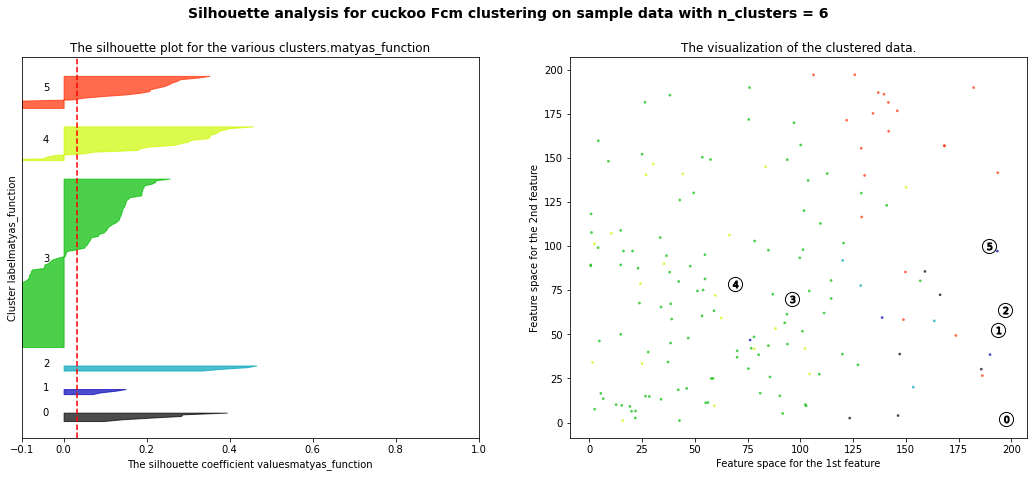

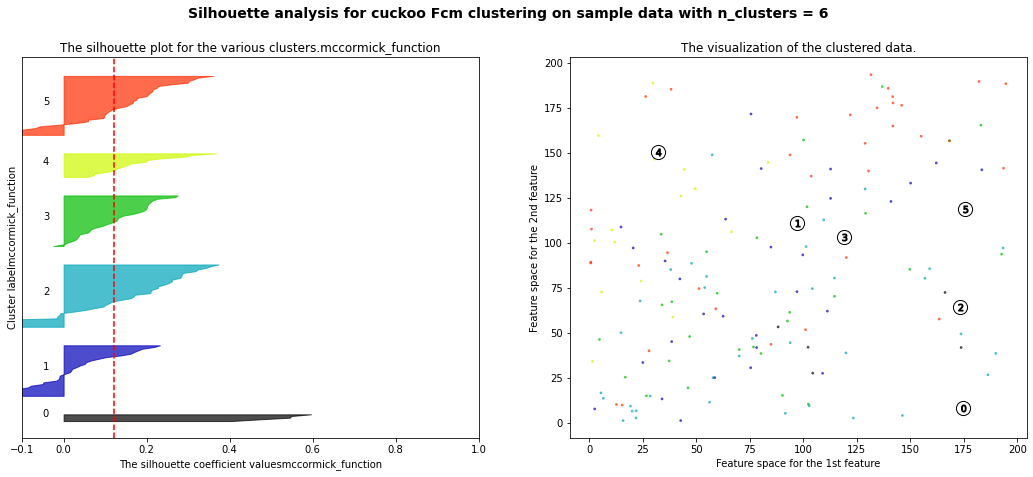

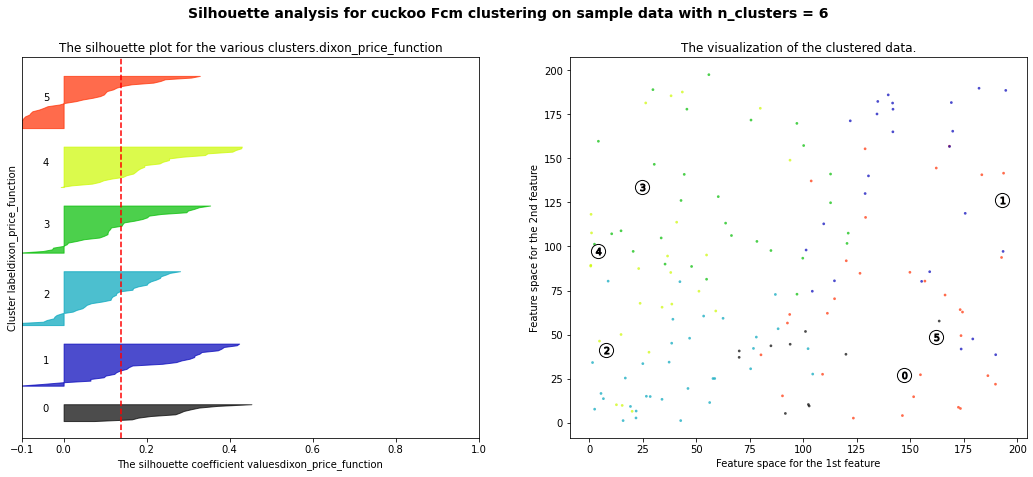

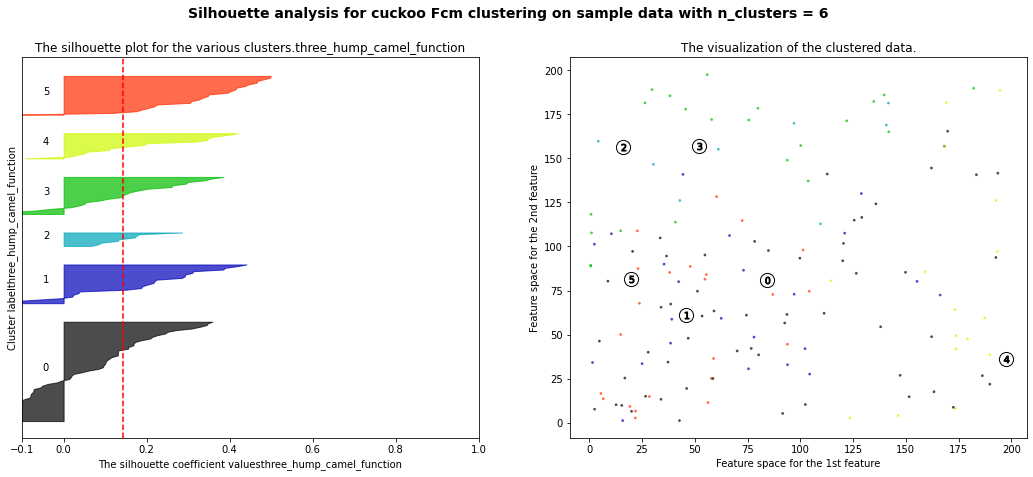

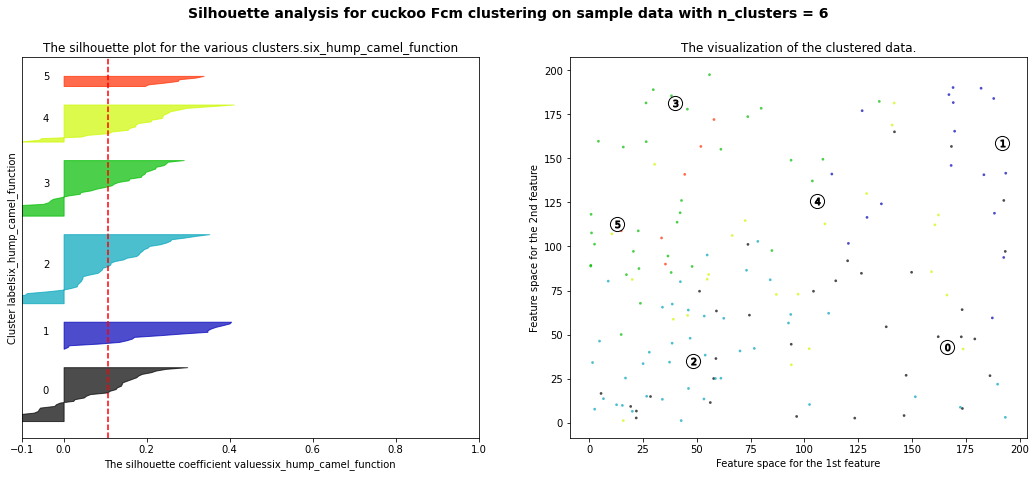

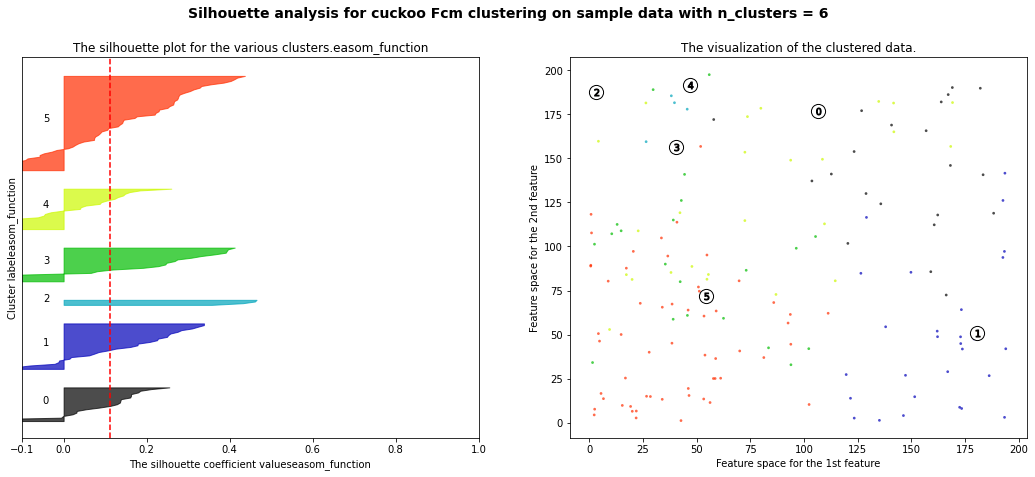

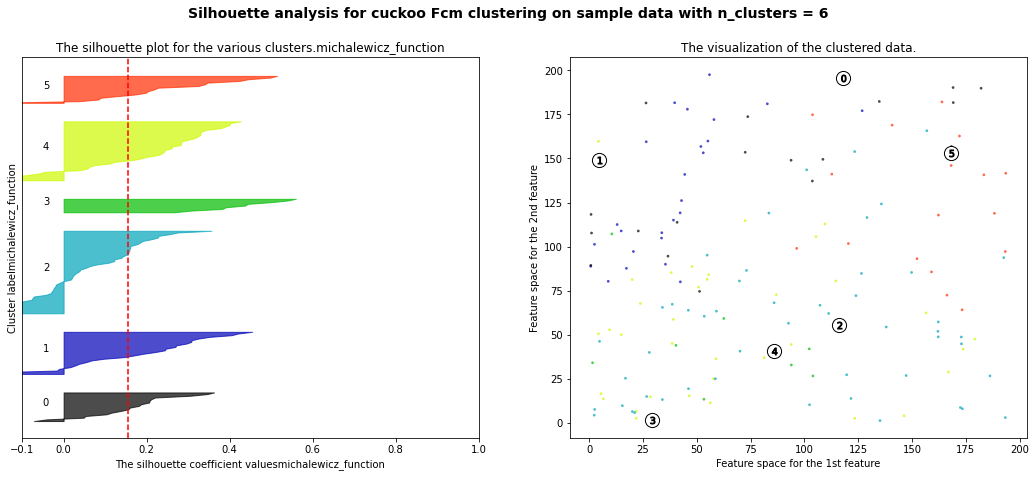

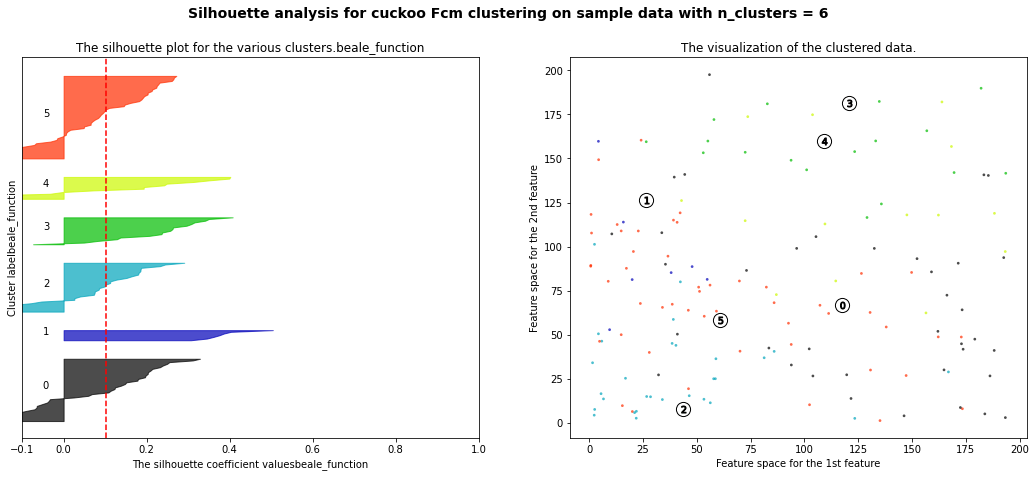

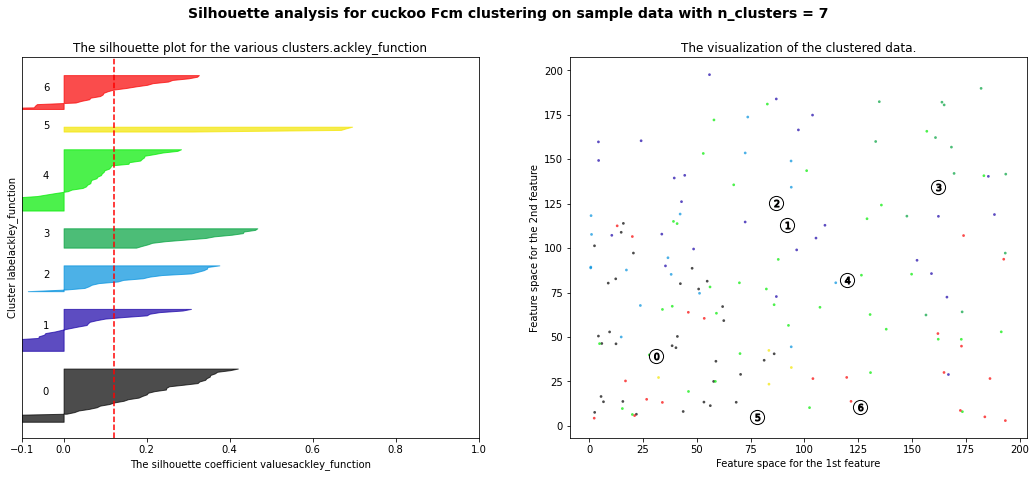

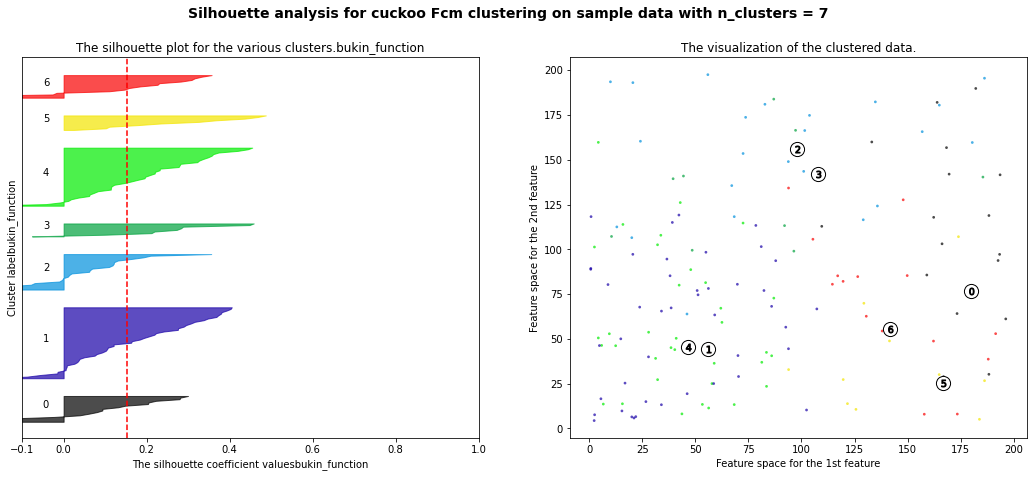

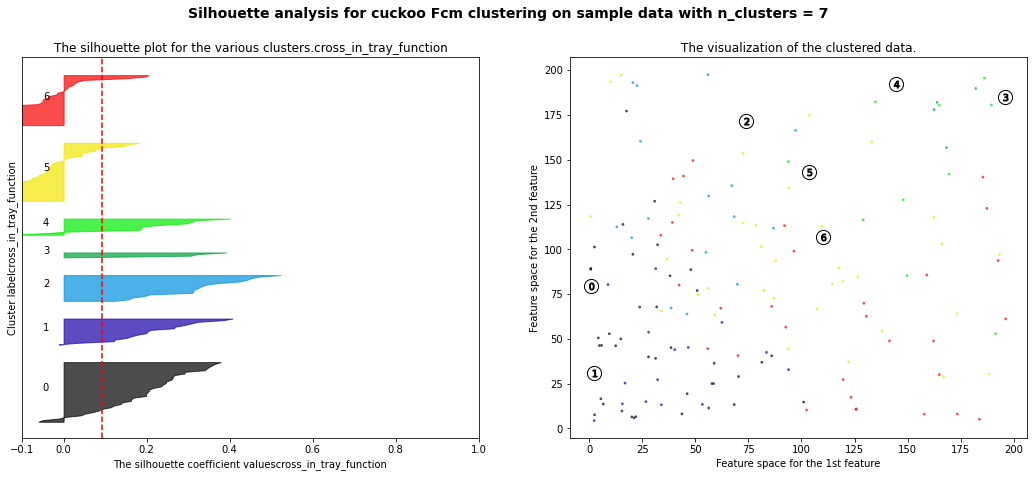

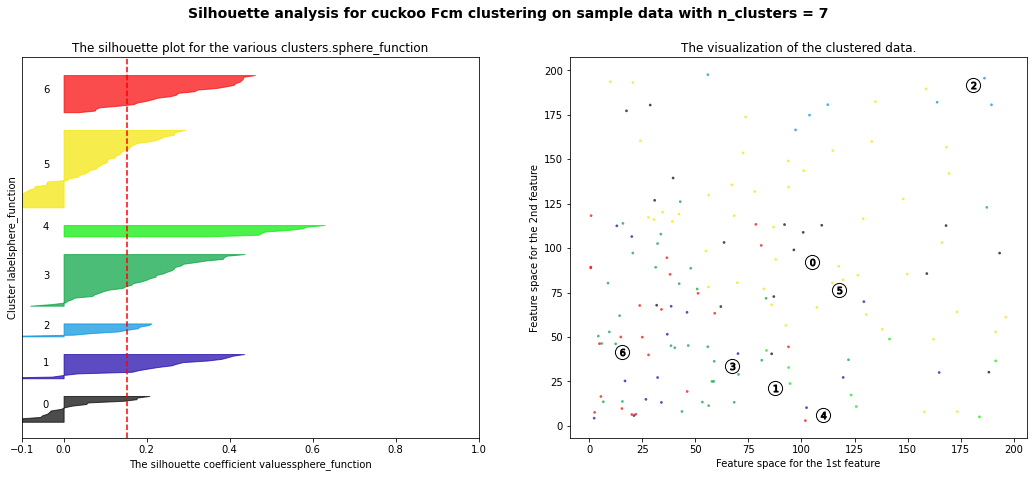

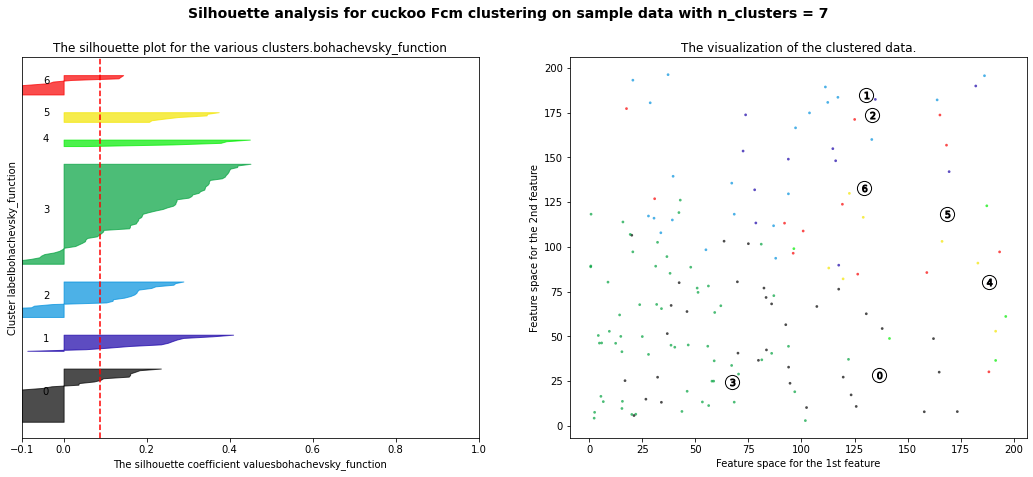

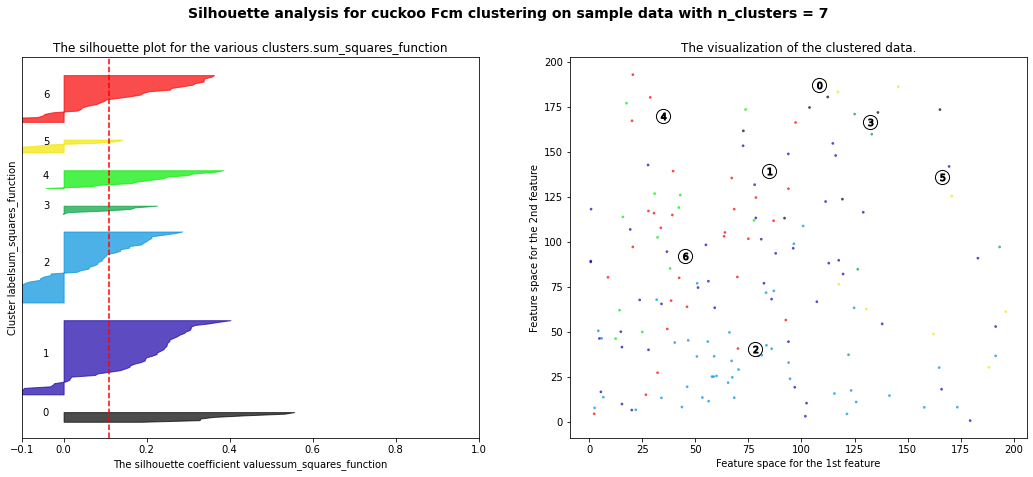

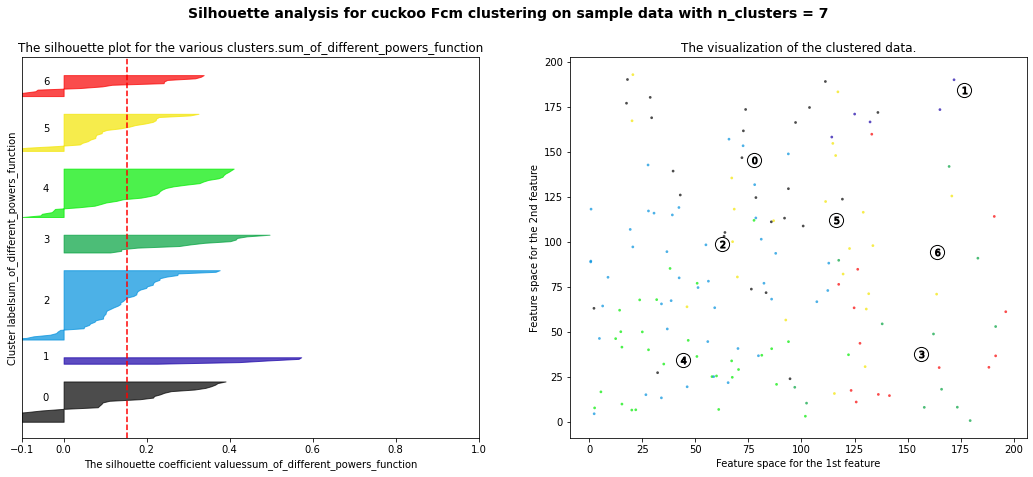

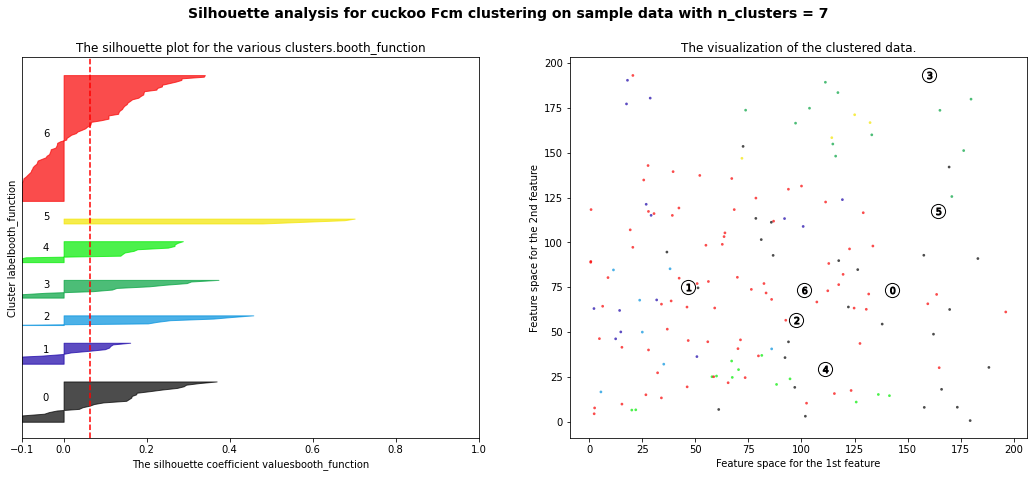

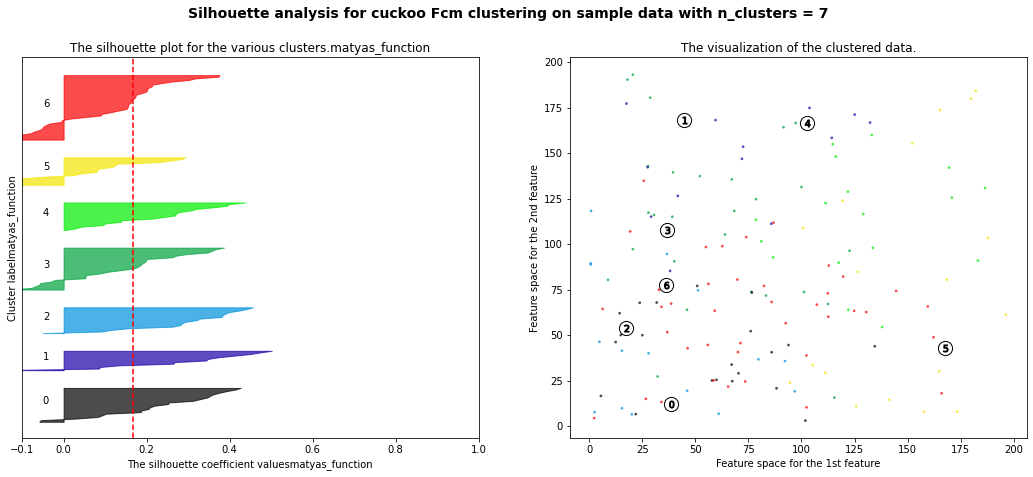

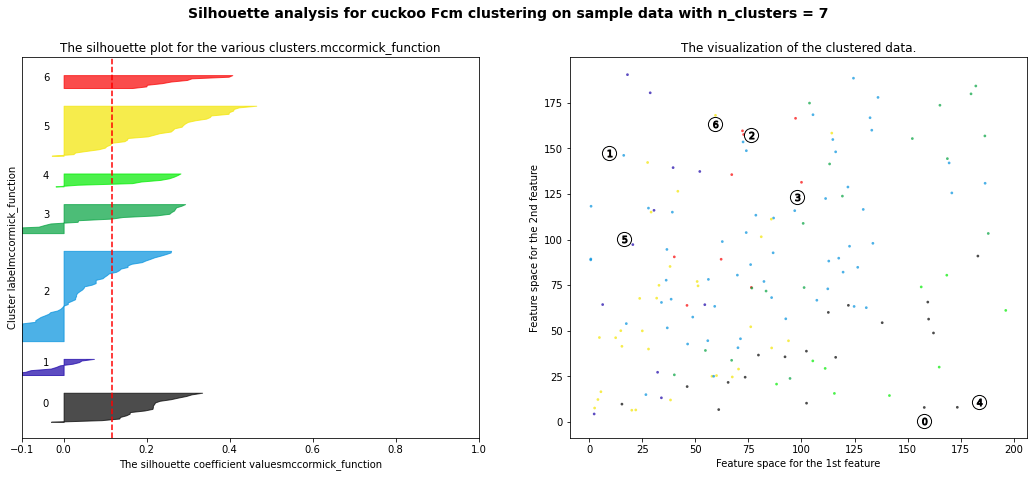

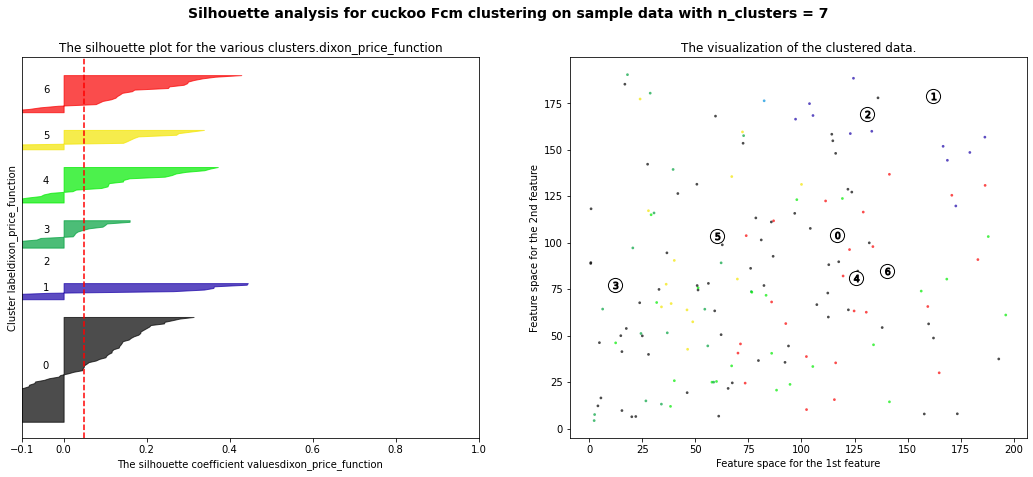

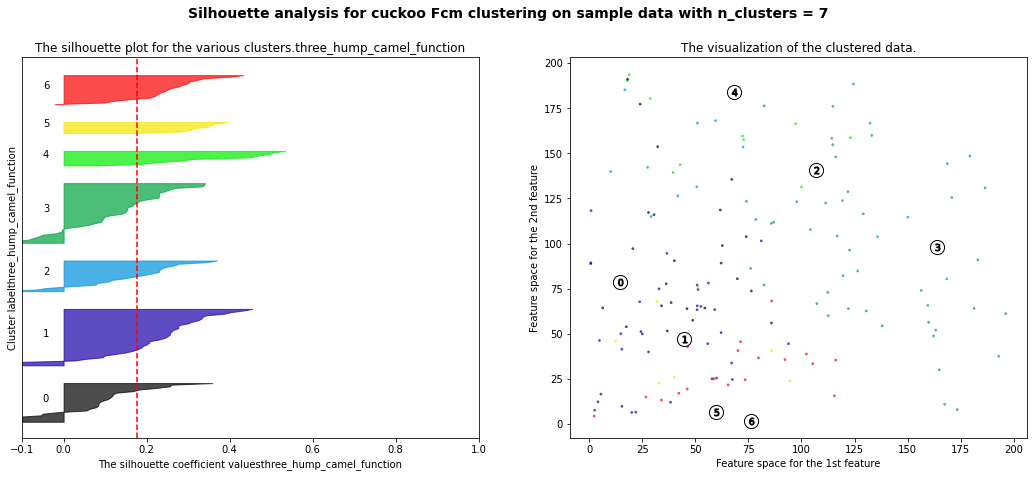

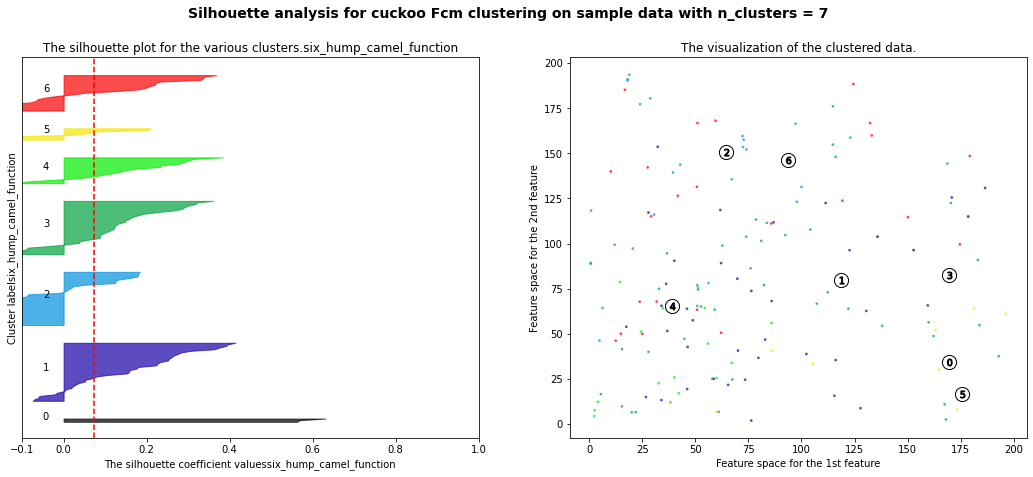

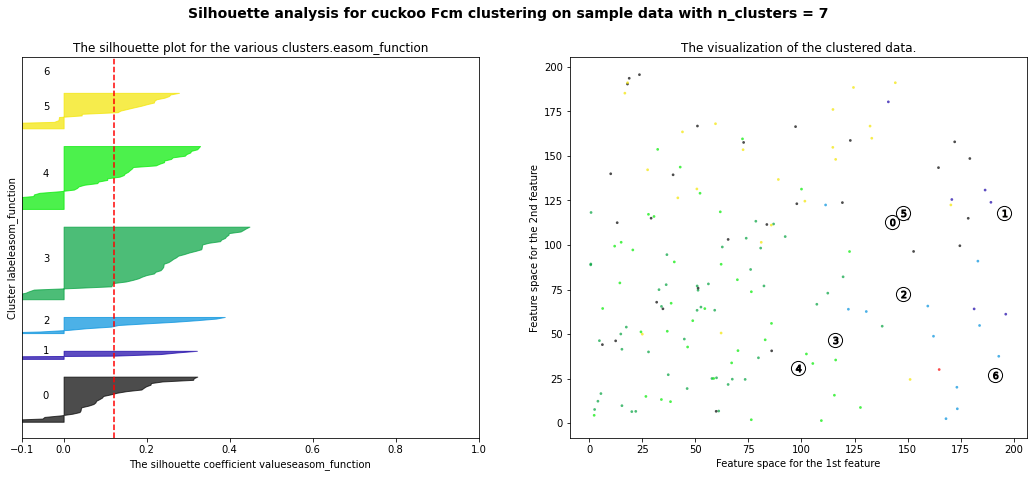

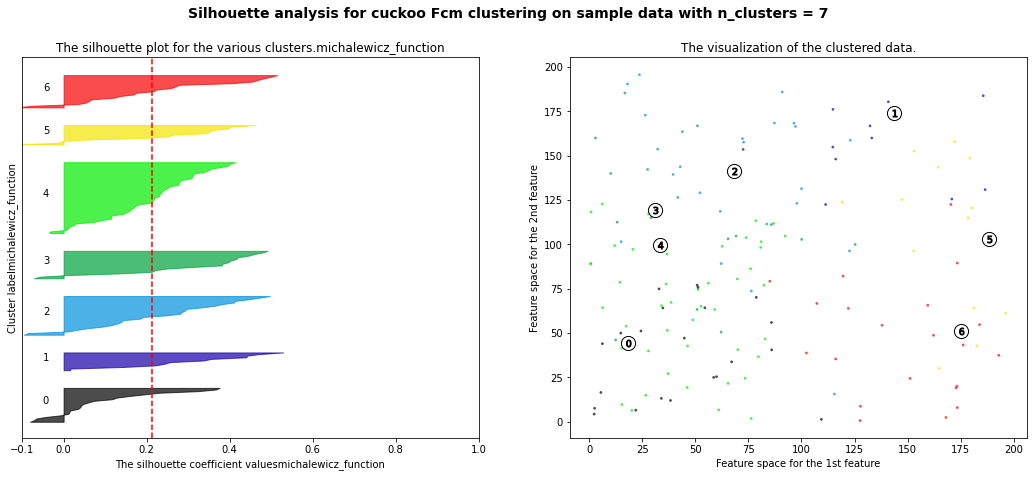

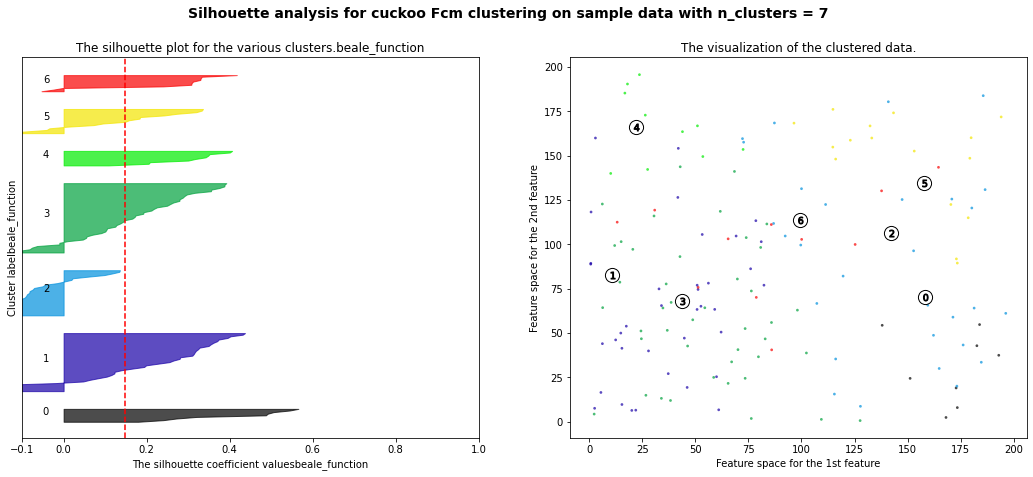

In [14]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
silhouette = []
range_n_clusters = [2, 3, 4, 5, 6,7]
X  = df_req[['Stride Length (m)', 'Cadence(steps/min)', 'Leg Length (m)',
       'Age(years)']].values
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    for g in w:
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_size_inches(18, 7)

      # The 1st subplot is the silhouette plot
      # The silhouette coefficient can range from -1, 1 but in this example all
      # lie within [-0.1, 1]
      ax1.set_xlim([-0.1, 1])
      # The (n_clusters+1)*10 is for inserting blank space between silhouette
      # plots of individual clusters, to demarcate them clearly.
      ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

      # Initialize the clusterer with n_clusters value and a random generator
      # seed of 10 for reproducibility.

      a = cso(n_clusters,g,X.max(),X.min(),4,25,values = X)
      fcm = FCM(n_clusters=n_clusters)
      fcm.centers = a.get_agents()[0]
      cluster_labels = fcm.predict(X)
      # The silhouette_score gives the average value for all the samples.
      # This gives a perspective into the density and separation of the formed
      # clusters
      silhouette_avg = silhouette_score(X, cluster_labels)
      silhouette.append(silhouette_avg)
      print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg,'function is :',g.__name__)

      # Compute the silhouette scores for each sample
      sample_silhouette_values = silhouette_samples(X, cluster_labels)

      y_lower = 10
      for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

      ax1.set_title("The silhouette plot for the various clusters." + g.__name__)
      ax1.set_xlabel("The silhouette coefficient values" + g.__name__)
      ax1.set_ylabel("Cluster label" + g.__name__)

      # The vertical line for average silhouette score of all the values
      ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

      ax1.set_yticks([])  # Clear the yaxis labels / ticks
      ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

      # 2nd Plot showing the actual clusters formed
      colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
      ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

      # Labeling the clusters
      centers = np.array(a.get_agents()[0])
      # Draw white circles at cluster centers
      ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

      for i, c in enumerate(centers):
          ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

      ax2.set_title("The visualization of the clustered data.")
      ax2.set_xlabel("Feature space for the 1st feature")
      ax2.set_ylabel("Feature space for the 2nd feature")

      plt.suptitle(("Silhouette analysis for cuckoo Fcm clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [15]:
import plotly.graph_objects as go

x = [i.__name__ for i in w]
y = silhouette[:len(x)]
print('cluster 2')
fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.show()

cluster 2


In [16]:
import plotly.graph_objects as go

x = [i.__name__ for i in w]
y = silhouette[len(x):len(x)*2]
print('cluster 3')
fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.show()

cluster 3


In [17]:
import plotly.graph_objects as go

x = [i.__name__ for i in w]
y = silhouette[len(x)*2:len(x)*3]
print('cluster 4')
fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.show()

cluster 4


In [18]:
import plotly.graph_objects as go

x = [i.__name__ for i in w]
y = silhouette[len(x)*3:len(x)*4]
print('cluster 5')
fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.show()

cluster 5


In [19]:
import plotly.graph_objects as go

x = [i.__name__ for i in w]
y = silhouette[len(x)*4:len(x)*5]
print('cluster 6')
fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.show()

cluster 6


In [20]:
import plotly.graph_objects as go

x = [i.__name__ for i in w]
y = silhouette[len(x)*5:len(x)*6]
print('cluster 7')
fig = go.Figure(data=go.Scatter(x=x, y=y))
fig.show()

cluster 7
